# Verify the algorithm's advantages on the HCP dataset


- KL divergence

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import itertools
def kl_divergence(p, q):
    """
    Calculate the symmetric KL divergence
    p, q: Probability distribution, which must ensure that the shapes of the two are the same and their value ranges are within [0, 1]
    """
    # Avoid taking the logarithm of 0 and dividing it by zero
    p = np.where(p == 0, np.finfo(float).eps, p)
    q = np.where(q == 0, np.finfo(float).eps, q)
    # kl = np.sum(p * np.log(p / q))
    kl = 0.5*(np.sum(p * np.log(p/q)) + np.sum(q * np.log(q/p)))
    return kl
# Define a function to detect and remove outliers
def remove_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

In [ ]:
##Calculate the kl divergence of the leida method for identifying different task state Spaces
condition = ['rest1', 'motor', 'emotion', 'gambling', 'language', 'relational', 'social', 'wm']
leida_kl = []
for k in range(2,21):
    file_path = f'/data/dzy/combined_method/NET/LEiDA_results_RL_net/dynamics_metrics/k_{k}/occupancies.csv'
    metric_data = pd.read_csv(file_path, sep='\t')
#     print(metric_data)
    for condition1, condition2 in itertools.combinations(condition, 2):
#         metric_data['condition'] = metric_data['condition'].replace({'rest1': 'rest', 'rest2': 'rest'})
        metric1 = metric_data[metric_data['condition'] == condition1]
        metric2 = metric_data[metric_data['condition'] == condition2]
        kl1={}
        for i in range(0,590):
            occ1 = metric1.iloc[i,2:].values
            occ1 = pd.DataFrame(occ1, dtype=float)
            occ2 = metric2.iloc[i,2:].values
            occ2 = pd.DataFrame(occ2, dtype=float)
            kl1[i] = kl_divergence(occ1,occ2)
        kl1 = pd.Series(kl1)
        kl1 = remove_outliers(kl1)
        kl1_values = kl1.values.tolist()
        mean_kl1 = np.mean(kl1_values)
        leida_kl.append({'k':k, 'task1':condition1, 'task2':condition2, 'mean_kl':mean_kl1,'kl_values':kl1_values})
for result in leida_kl:
    print(f"k: {result['k']}, task1: {result['task1']}, task2: {result['task2']}, mean_kl: {result['mean_kl']}")
df = pd.DataFrame(leida_kl)
df.to_csv('/data/dzy/combined_method/leida_RL_net.csv', index=False, encoding='utf-8')

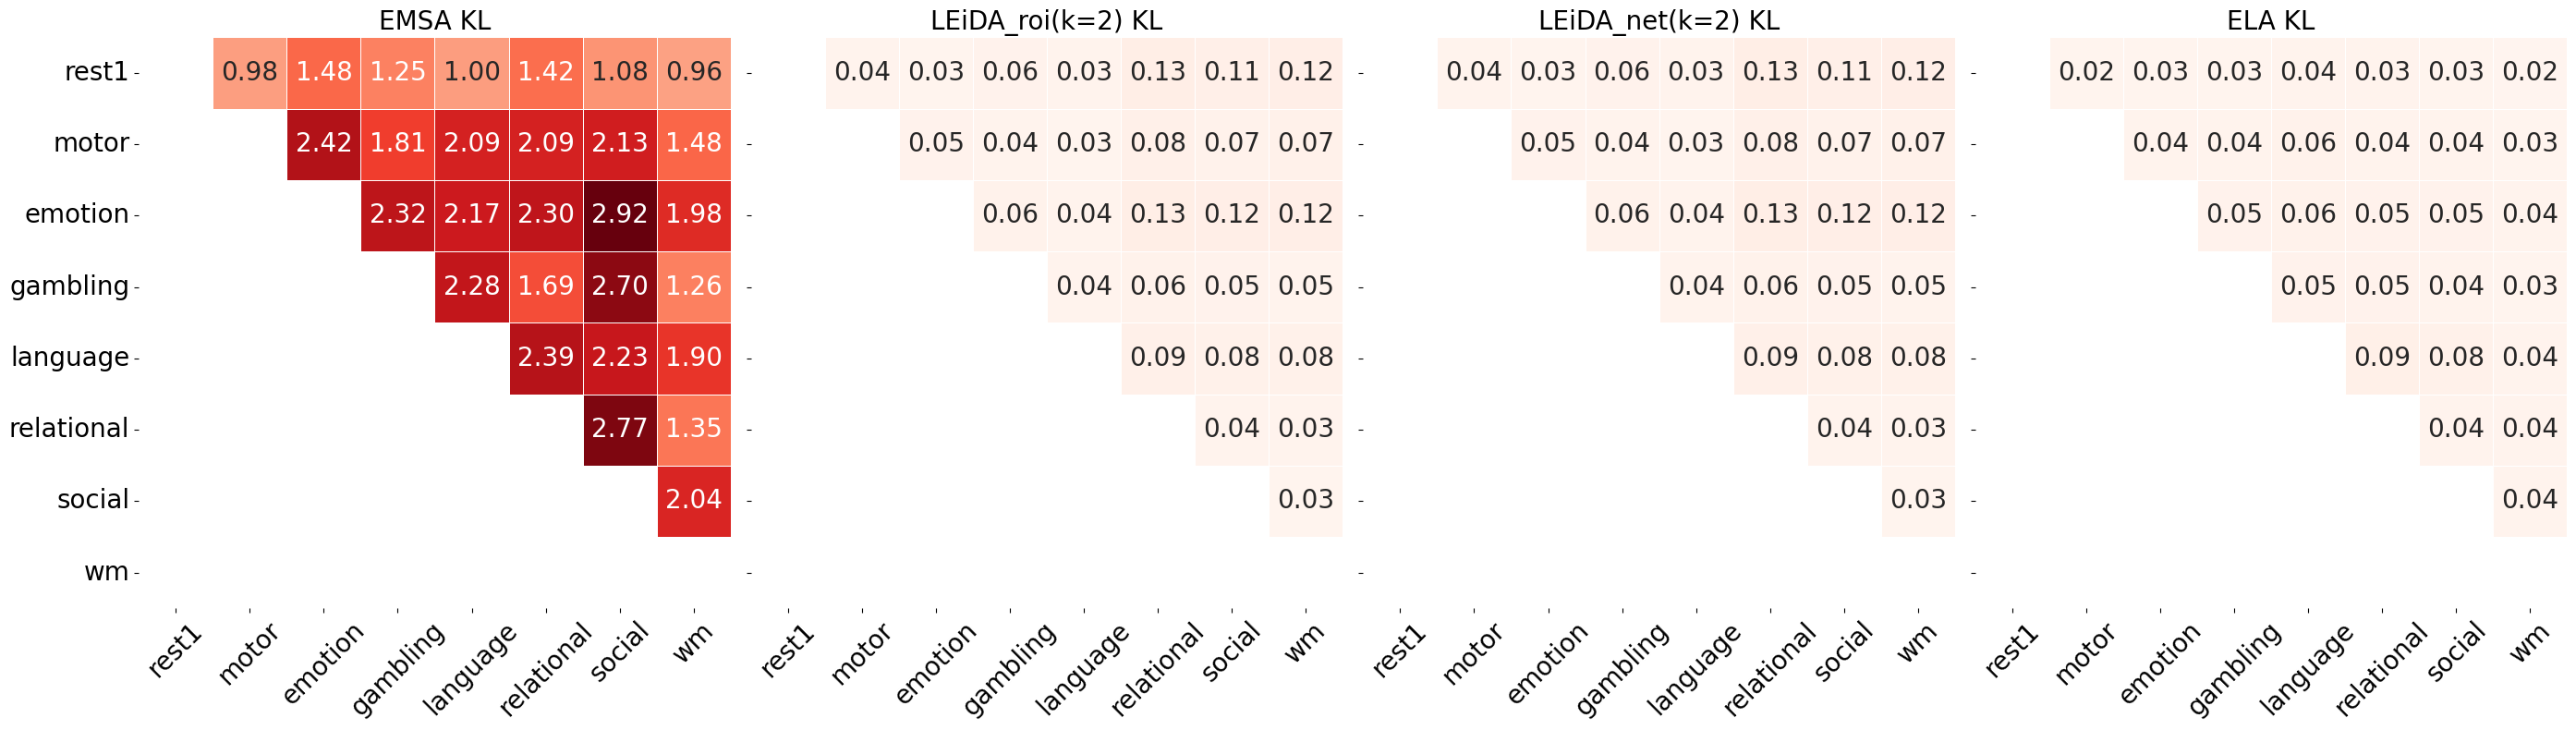

<Figure size 640x480 with 0 Axes>

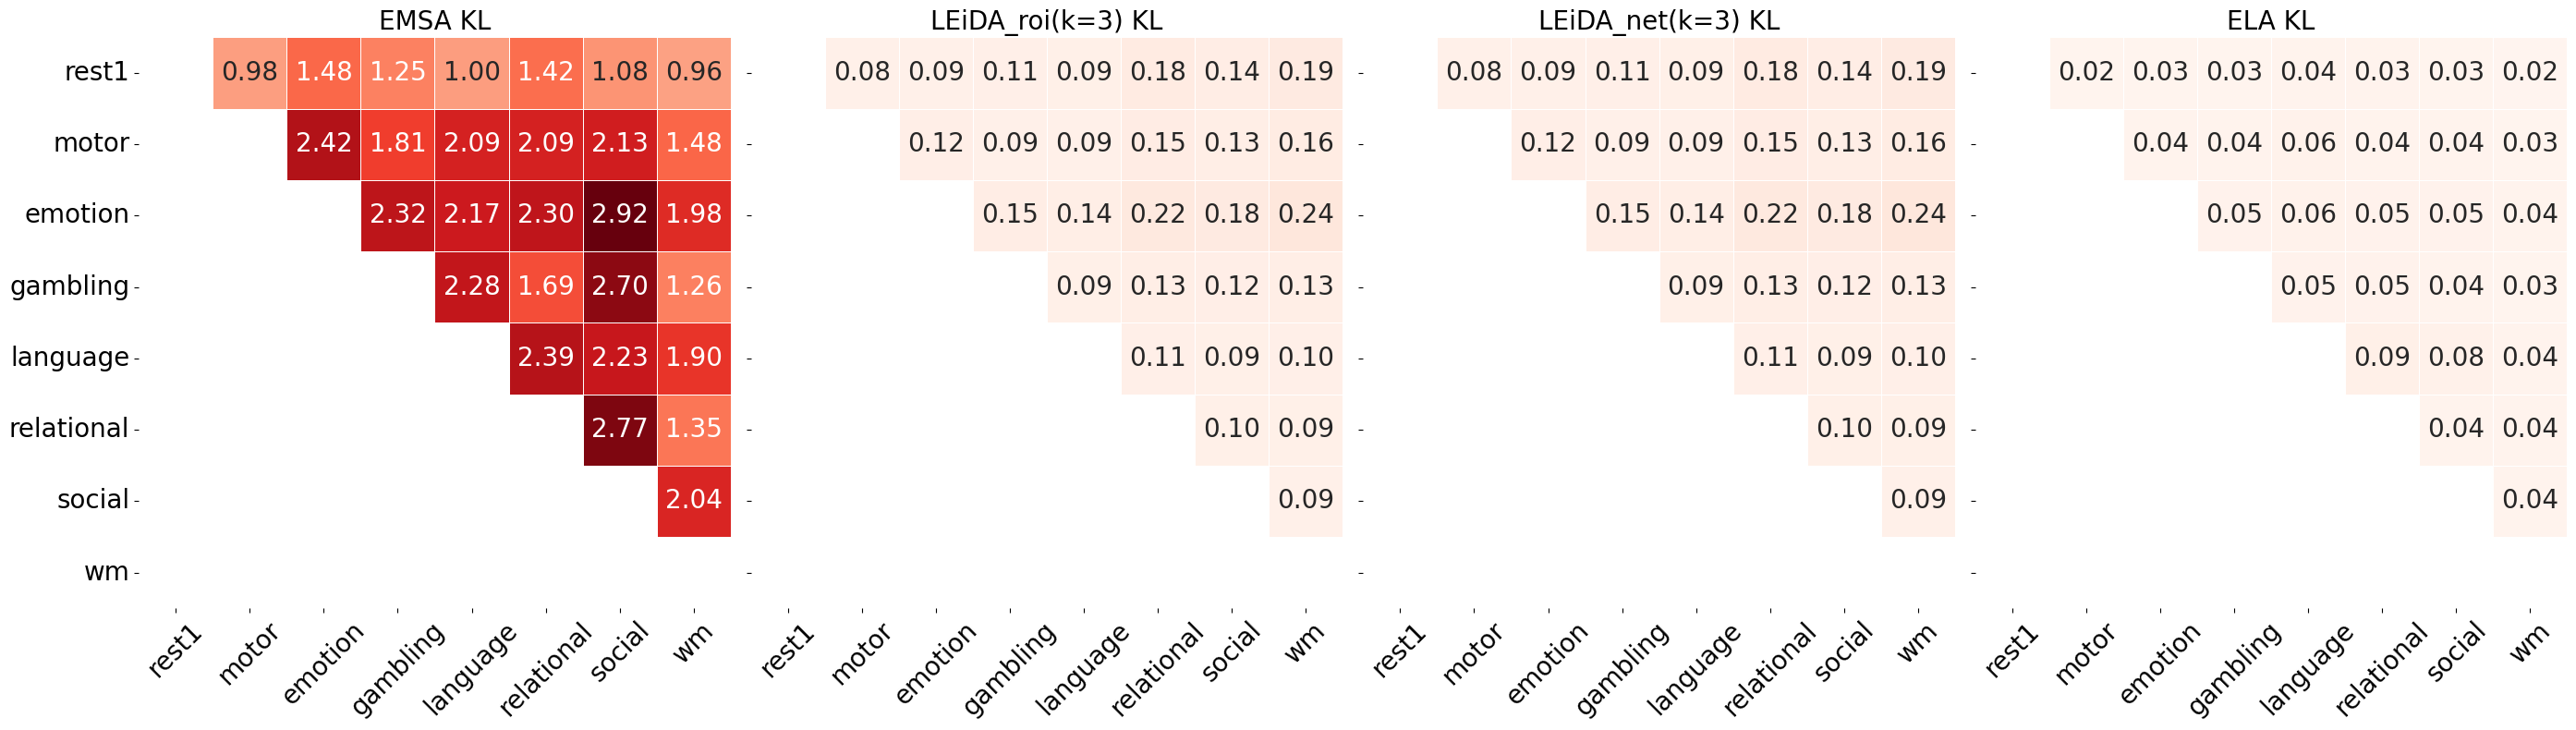

<Figure size 640x480 with 0 Axes>

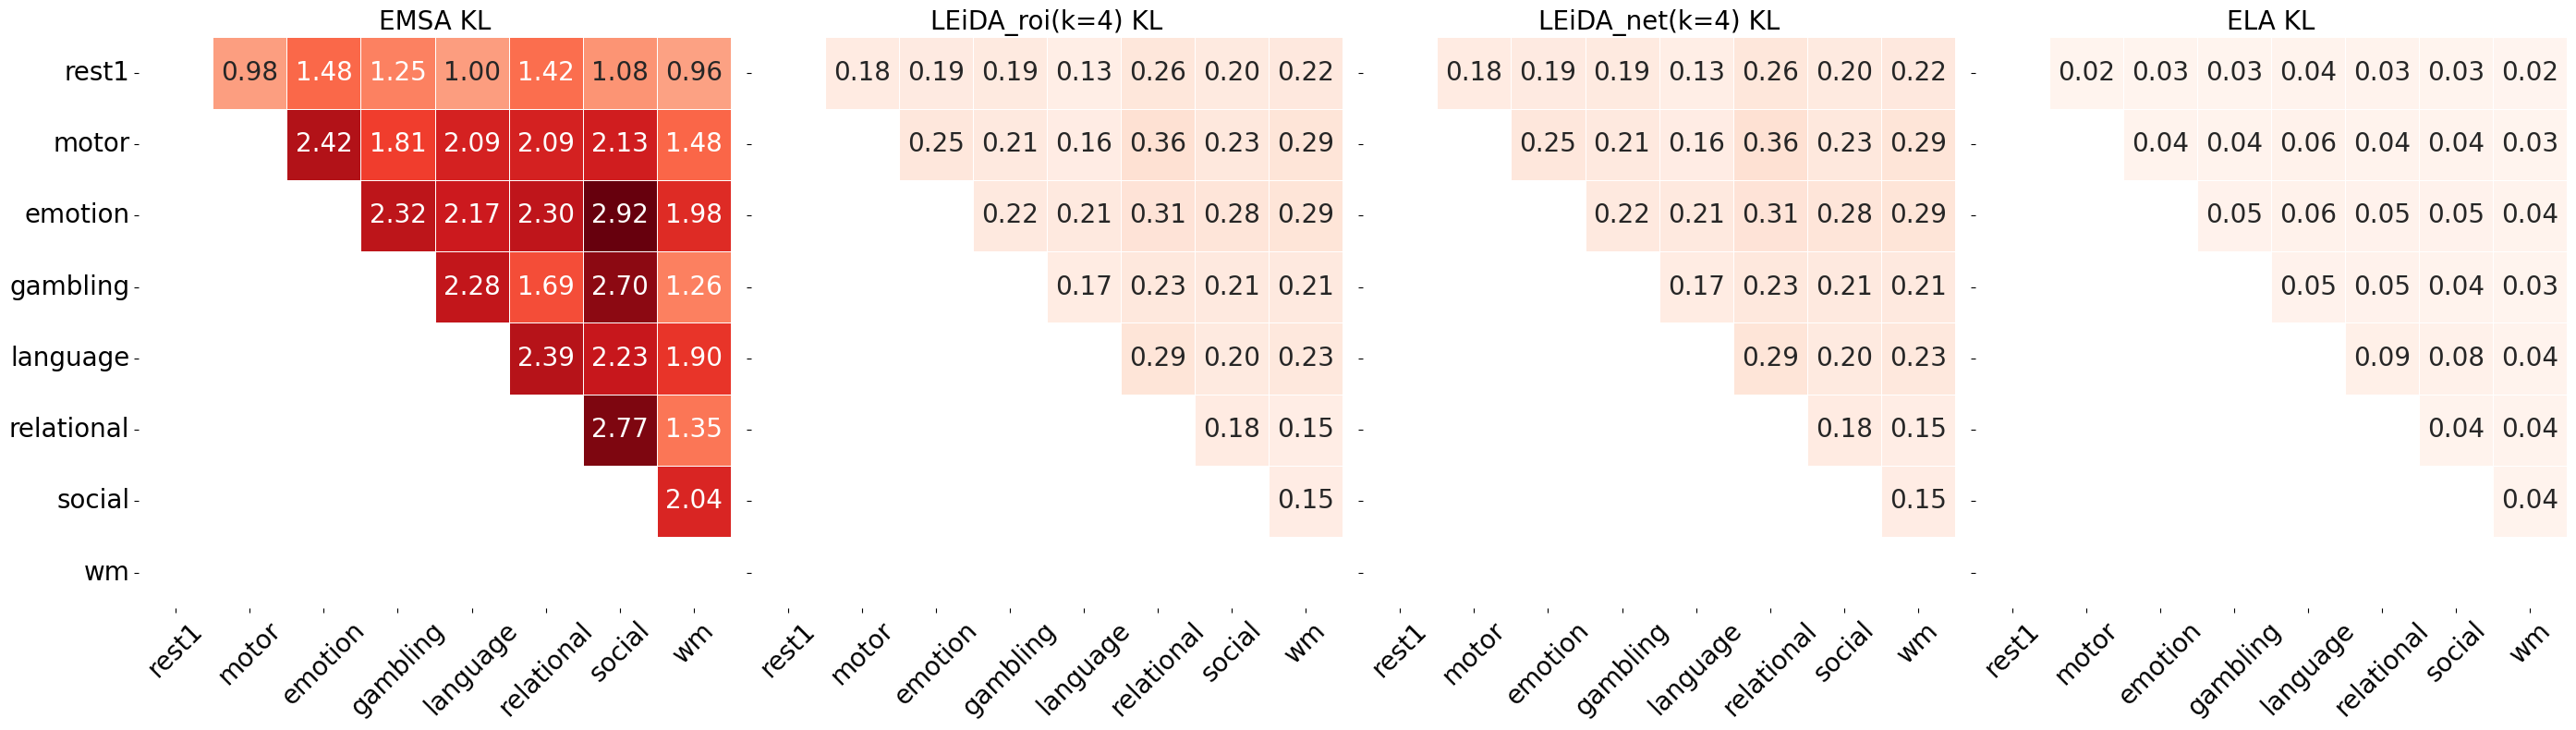

<Figure size 640x480 with 0 Axes>

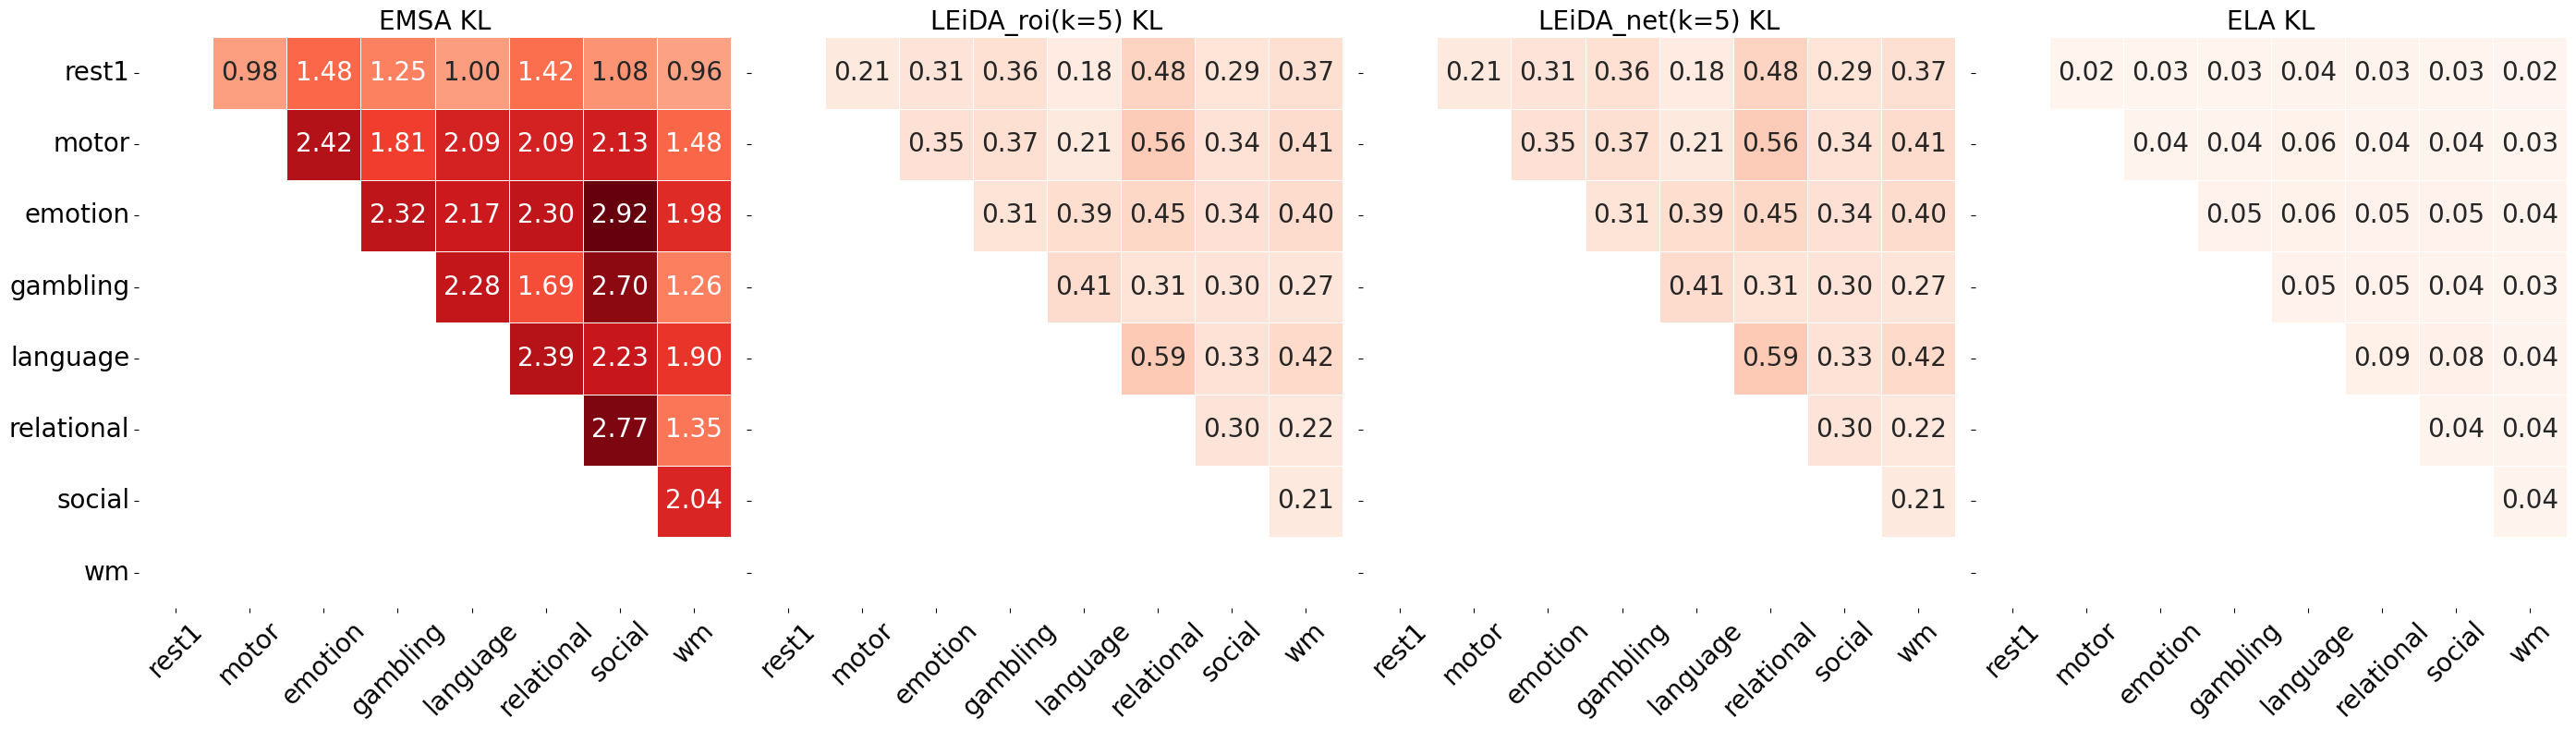

<Figure size 640x480 with 0 Axes>

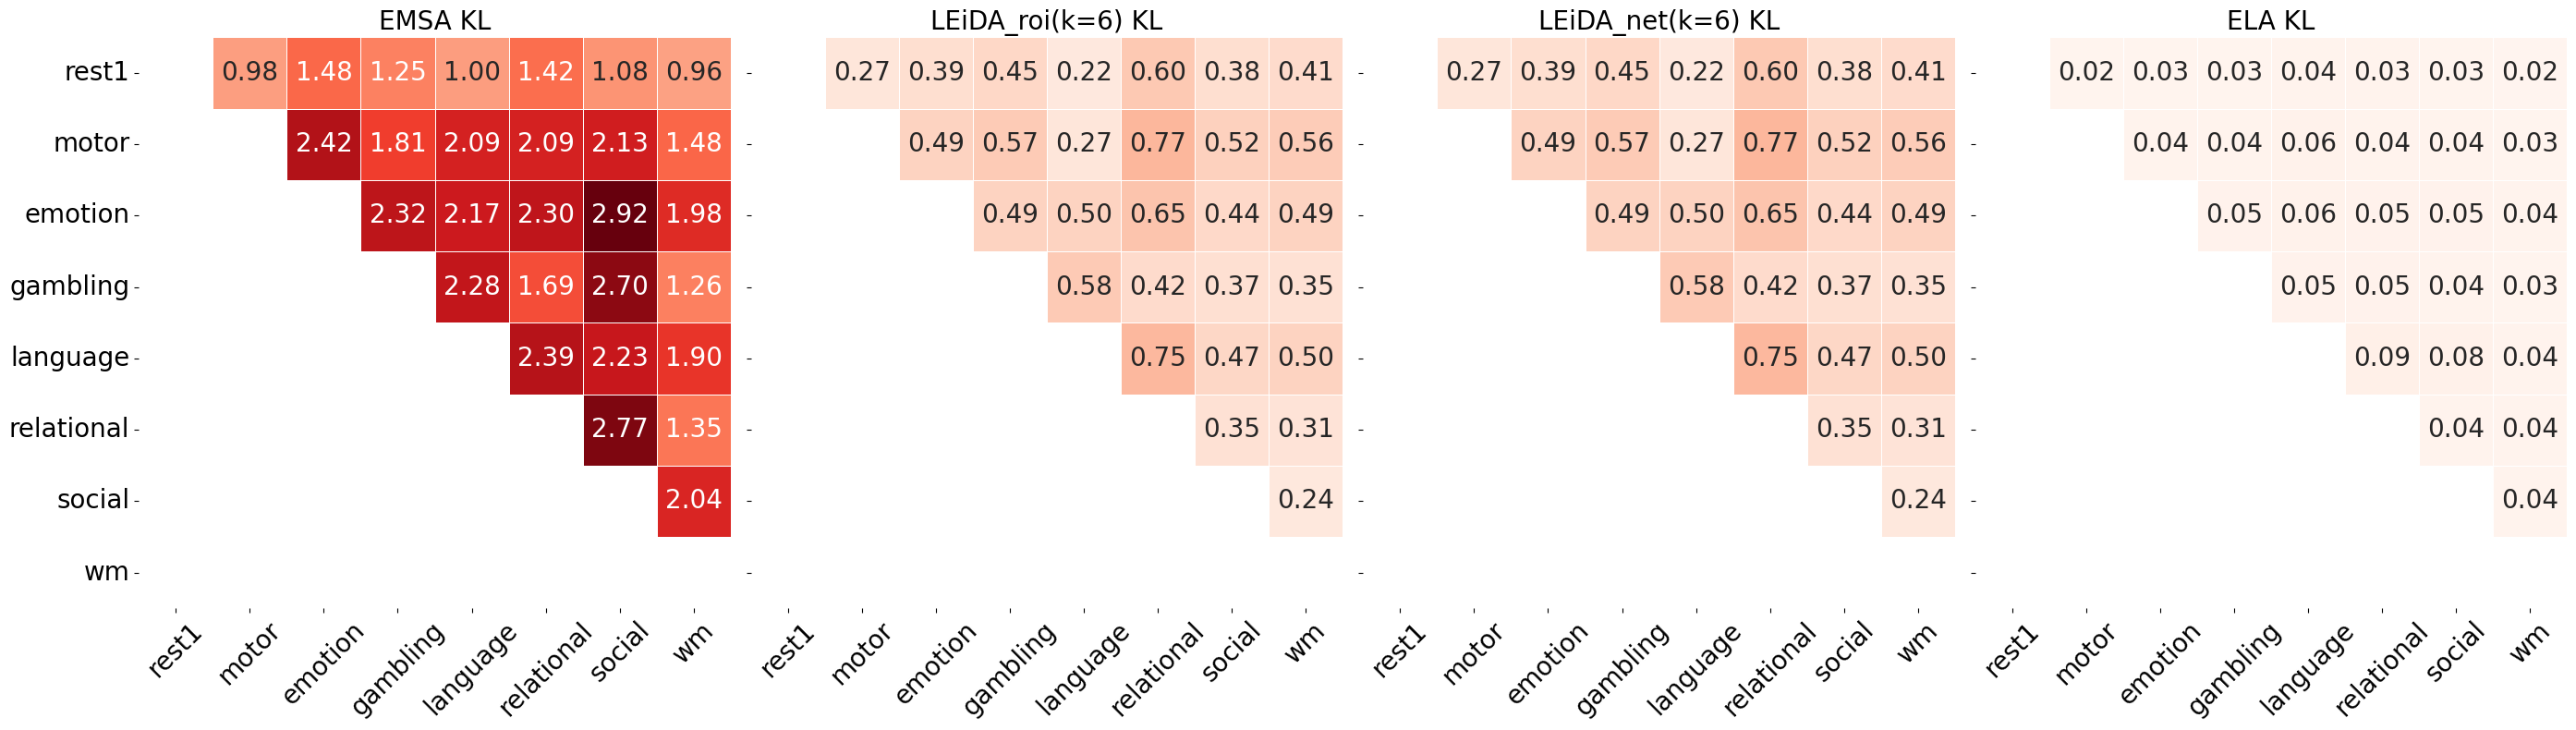

<Figure size 640x480 with 0 Axes>

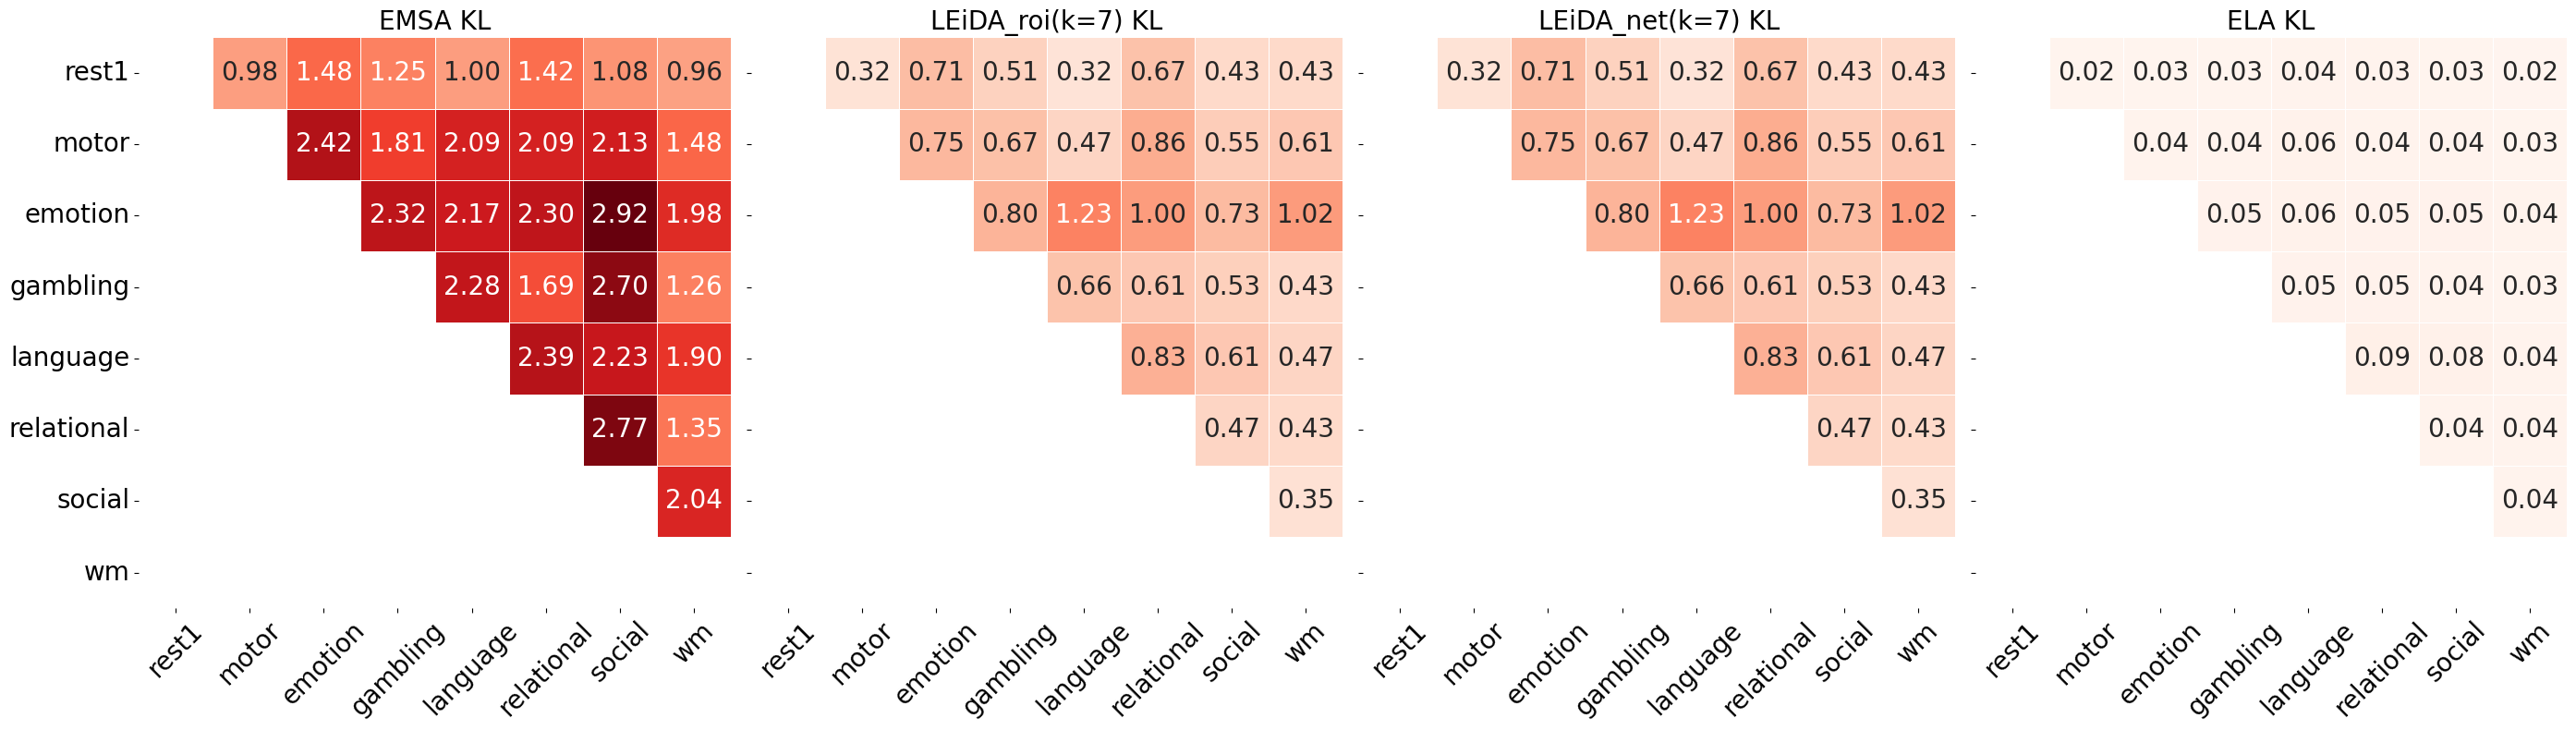

<Figure size 640x480 with 0 Axes>

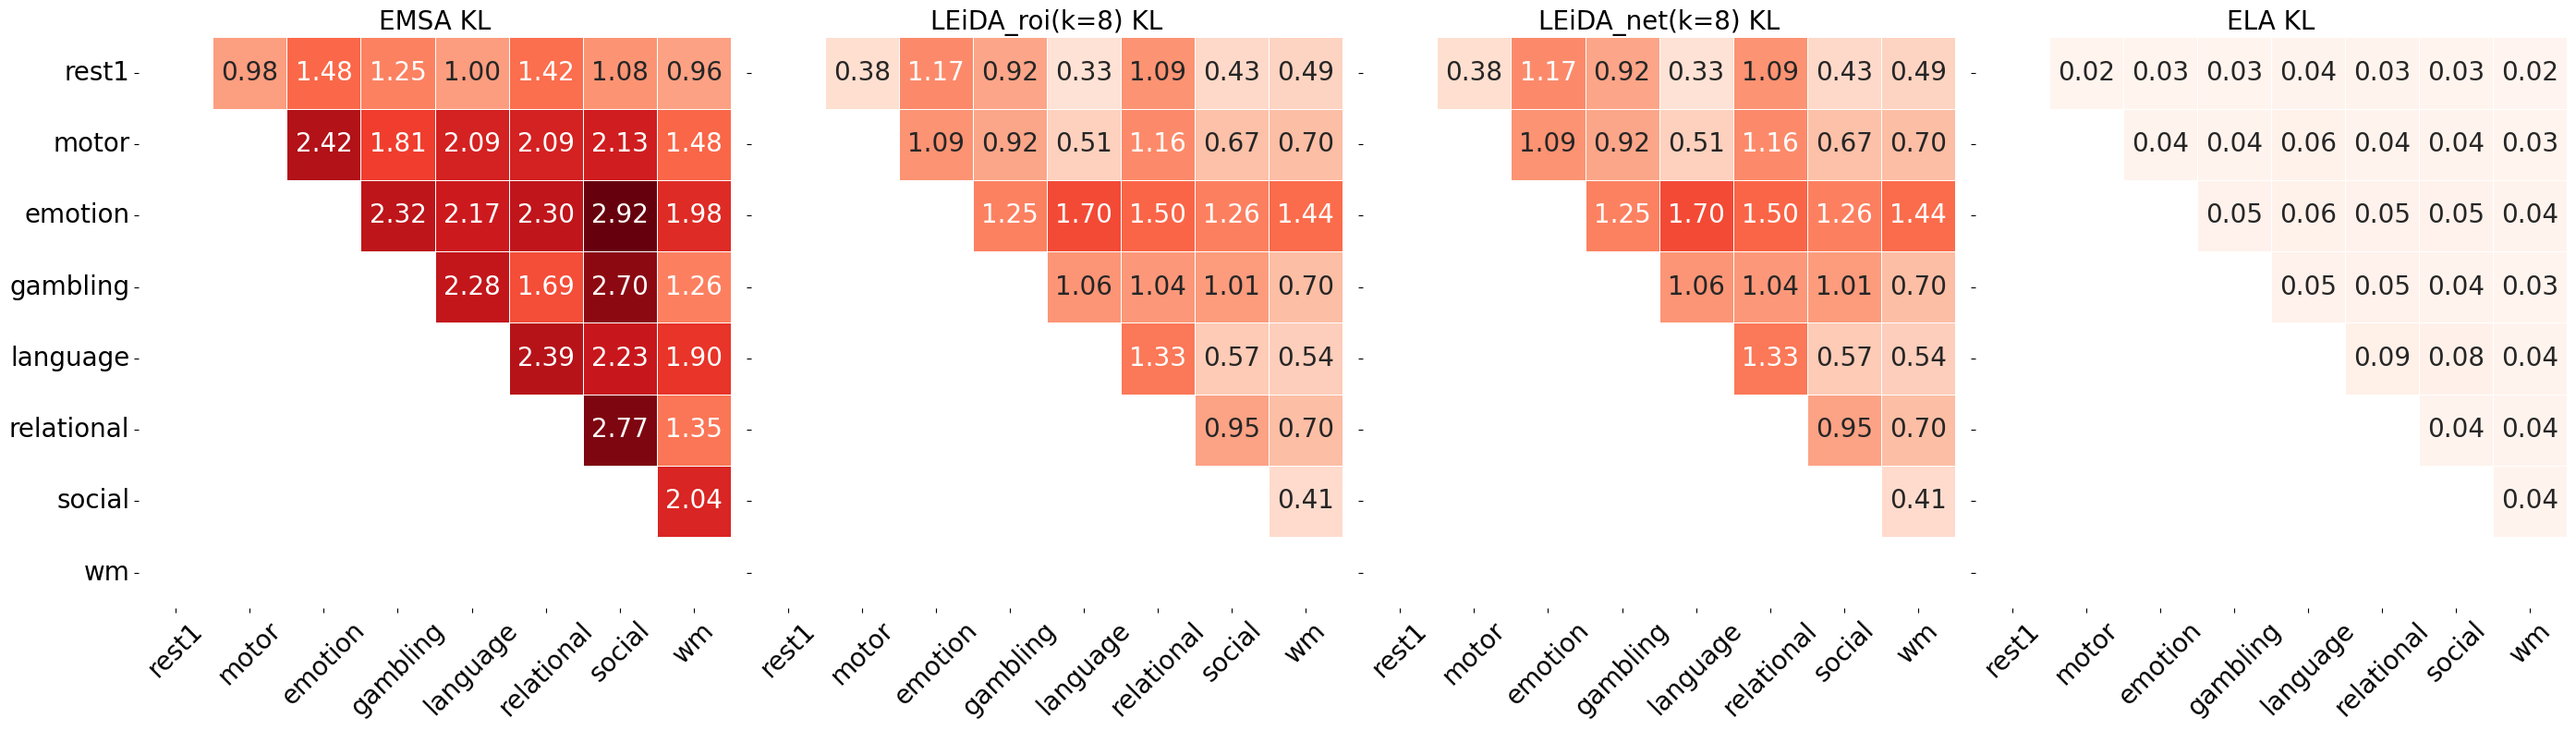

<Figure size 640x480 with 0 Axes>

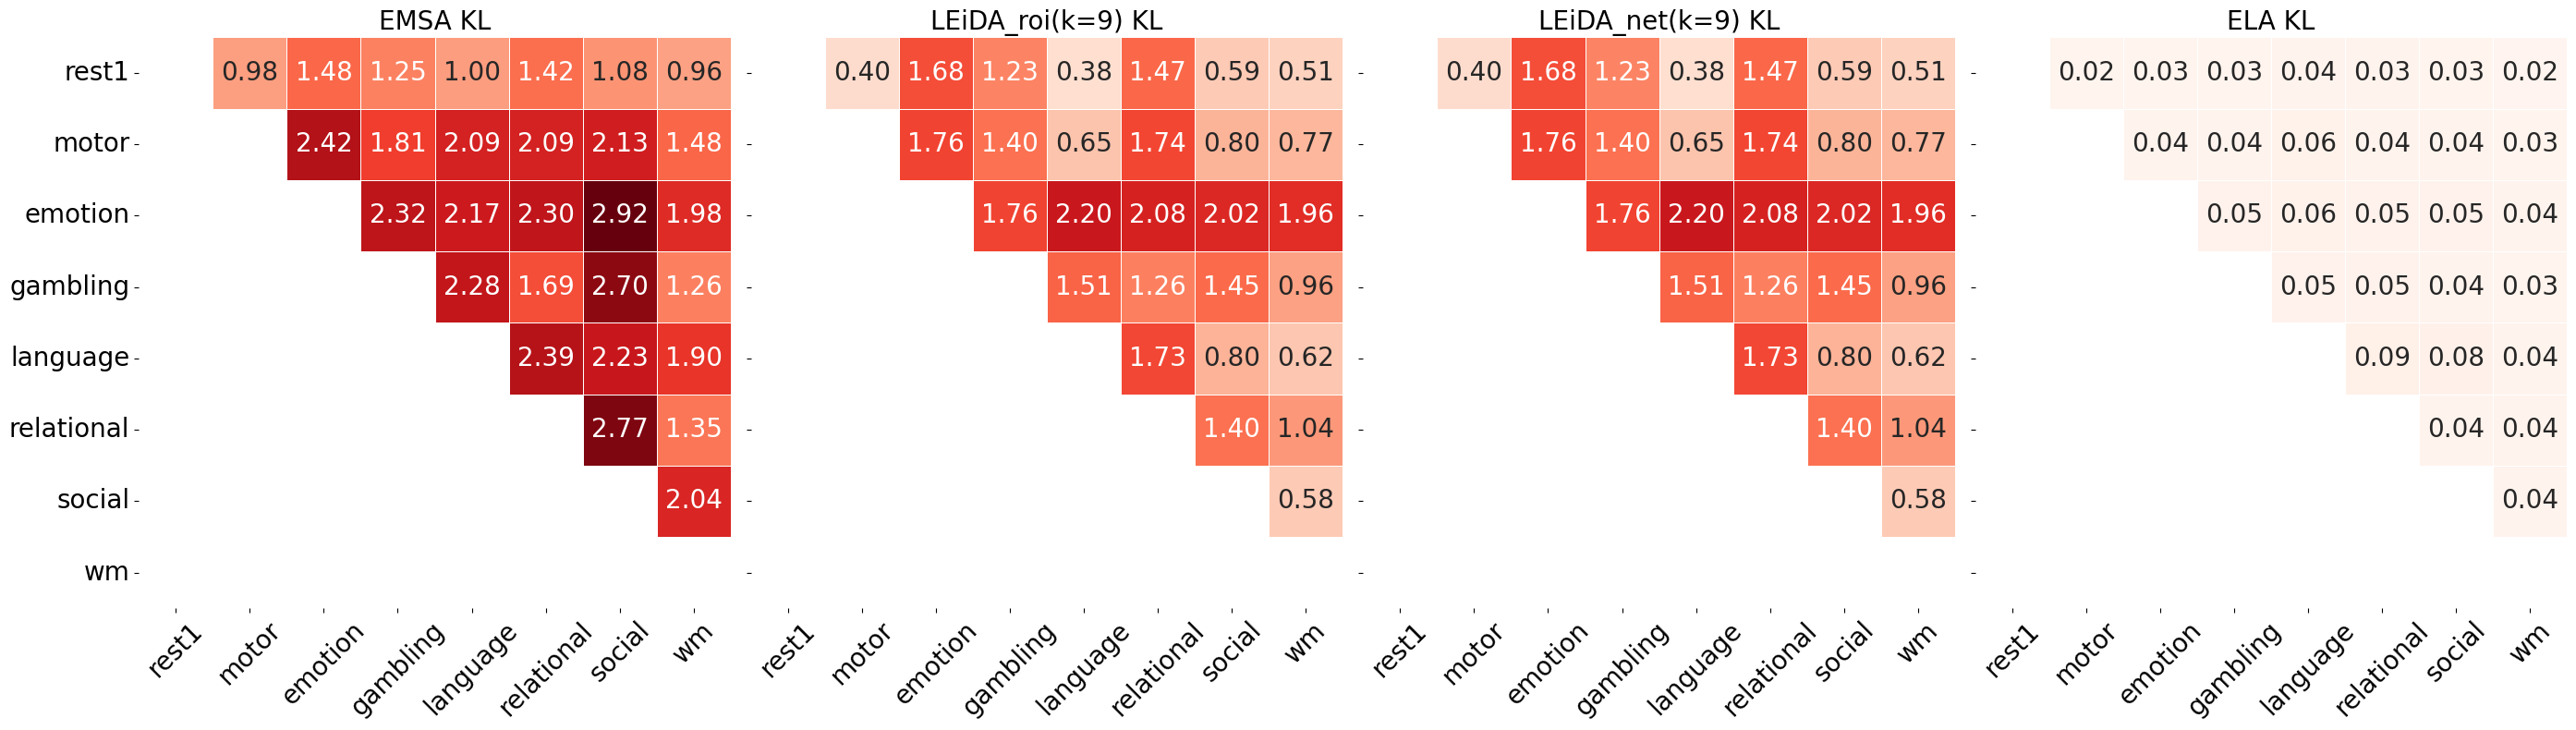

<Figure size 640x480 with 0 Axes>

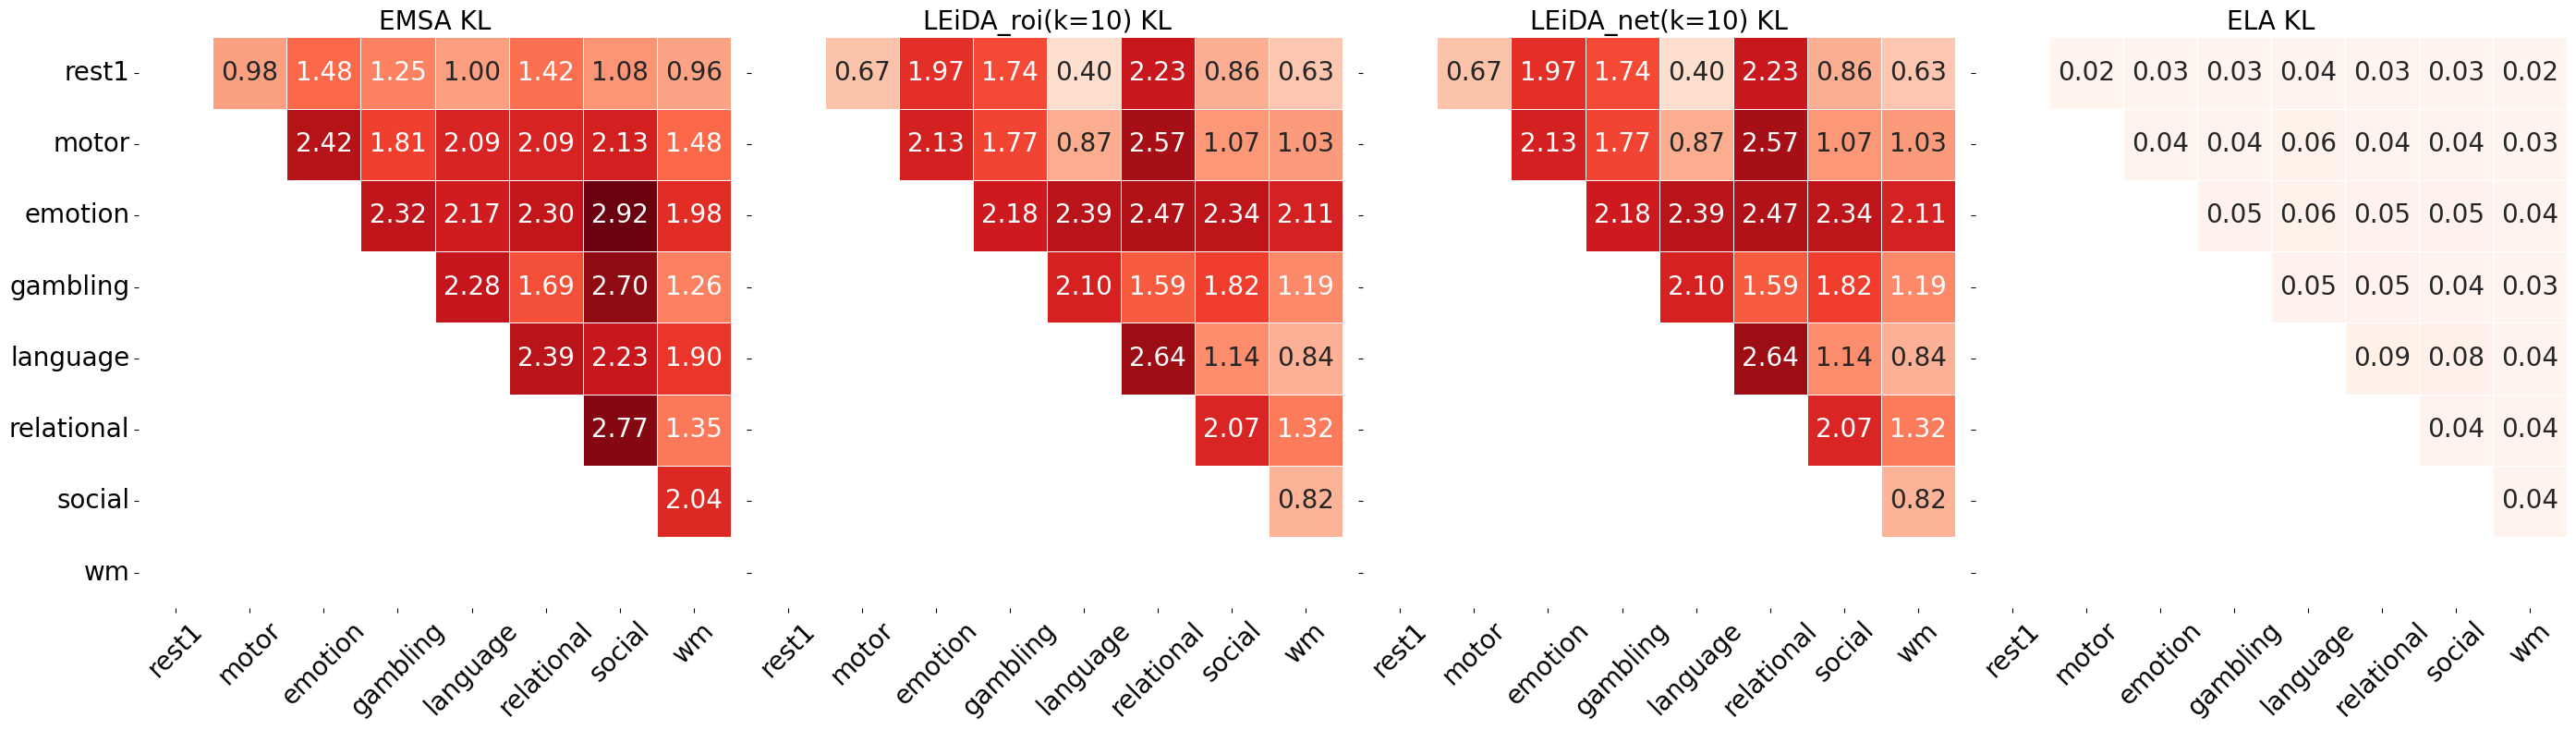

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

condition = ['rest1', 'motor', 'emotion', 'gambling', 'language', 'relational', 'social', 'wm']
kl_matrix1 = np.zeros((len(condition), len(condition)))
kl_matrix2 = np.zeros((len(condition), len(condition)))
kl_matrix3 = np.zeros((len(condition), len(condition)))
kl_matrix4 = np.zeros((len(condition), len(condition)))
data1 = pd.read_csv('/data/dzy/combined_method/leida_RL.csv')
data2 = pd.read_csv('/data/dzy/combined_method/leida_RL_net.csv')
df1 = pd.read_csv('/data/dzy/combined_method/结合方法_RL_kl.csv')
df2 = pd.read_csv('/data/dzy/combined_method/原始能量景观分析_RL_kl.csv')

for index, row in df1.iterrows():
    kl_matrix1[condition.index(row['task1']), condition.index(row['task2'])] = row['mean_kl']
for index, row in df2.iterrows():
    kl_matrix2[condition.index(row['task1']), condition.index(row['task2'])] = row['mean_kl']
kl_df1 = pd.DataFrame(kl_matrix1, index=condition, columns=condition)
kl_df2 = pd.DataFrame(kl_matrix2, index=condition, columns=condition)

for i in range(2,11):
    data1_each = data1.loc[data1['k'] == i]
    data2_each = data2.loc[data2['k'] == i]
    for index, row in data1_each.iterrows():
        kl_matrix3[condition.index(row['task1']), condition.index(row['task2'])] = row['mean_kl']
    for index, row in data2_each.iterrows():
        kl_matrix4[condition.index(row['task1']), condition.index(row['task2'])] = row['mean_kl']
    
    kl_df3 = pd.DataFrame(kl_matrix3, index=condition, columns=condition)
    kl_df4 = pd.DataFrame(kl_matrix3, index=condition, columns=condition)
    
    vmin = min(kl_matrix1.min(), kl_matrix2.min(), kl_matrix3.min(),kl_matrix4.min())
    vmax = max(kl_matrix1.max(), kl_matrix2.max(), kl_matrix3.max(),kl_matrix4.max())
    mask = np.tril(np.ones_like(kl_df1, dtype=bool))
    
    fig, axs = plt.subplots(1, 4, figsize=(28, 8))

    
    sns.heatmap(kl_df1, annot=True, cmap='Reds', fmt=".2f", linewidths=.5, ax=axs[0], vmin=vmin, vmax=vmax, cbar=False, mask=mask, annot_kws={'size': 20})
    axs[0].set_title('EPLSA KL', fontsize=20)  
    axs[0].set_xticklabels(condition, rotation=45, fontsize=20)  
    axs[0].set_yticklabels(condition, rotation=0, fontsize=20)  
    
    sns.heatmap(kl_df2, annot=True, cmap='Reds', fmt=".2f", linewidths=.5, ax=axs[3], vmin=vmin, vmax=vmax, cbar=False, mask=mask, annot_kws={'size': 20})
    axs[3].set_title('ELA KL', fontsize=20)  
    axs[3].set_xticklabels(condition, rotation=45, fontsize=20)  
    axs[3].set_yticklabels([])  

    sns.heatmap(kl_df3, annot=True, cmap='Reds', fmt=".2f", linewidths=.5, ax=axs[1], vmin=vmin, vmax=vmax, cbar=False, mask=mask, annot_kws={'size': 20})
    axs[1].set_title(f'LEiDA_roi(k={i}) KL', fontsize=20)
    axs[1].set_xticklabels(condition, rotation=45, fontsize=20) 
    axs[1].set_yticklabels([])  
    sns.heatmap(kl_df3, annot=True, cmap='Reds', fmt=".2f", linewidths=.5, ax=axs[2], vmin=vmin, vmax=vmax, cbar=False, mask=mask, annot_kws={'size': 20})
    axs[2].set_title(f'LEiDA_net(k={i}) KL', fontsize=20)  
    axs[2].set_xticklabels(condition, rotation=45, fontsize=20)  
    axs[2].set_yticklabels([])  
    
    plt.tight_layout()
    plt.show()
    plt.savefig(f'/data/dzy/combined_method/figure/RL/KL_martix_{i}')

In [ ]:
data1 = pd.read_csv('/data/dzy/combined_method/roi_mnr.csv')
data2 = pd.read_csv('/data/dzy/combined_method/net_mnr.csv')
df1 = pd.read_csv('/data/dzy/combined_method/结合方法_mnr.csv')
df1 = df1.drop(df1.columns[0:1], axis=1)
# df1 = df1.drop(index = 0)
df1 = df1.astype(float)
df2 = pd.read_csv('/data/dzy/combined_method/原始能量景观分析_mnr.csv')
df2 = df2.drop(df2.columns[0:1], axis=1)
# df2 = df2.drop(index = 0)
df2 = df2.astype(float)
print(df2.iloc[0:9,0])
roi_kl = {}
net_kl = {}
for k in range(2,11):
    kl_roi = data1[data1['k'] == k]
    roi_kl[k] = kl_roi['MNR'].tolist()
    kl_net = data2[data2['k'] == k]
    net_kl[k] = kl_net['MNR'].tolist()
roi_kl = pd.DataFrame(roi_kl)
net_kl = pd.DataFrame(net_kl)
print(net_kl)
pp = [None] * 9 * 9
group = []
m = 0
a = 0
for i in range(0,9):
    pp[9*a:9*(a+1)] = df1.iloc[0:9,0]
    pp[9*(a+1):9*(a+2)] = roi_kl.iloc[0:9,i]
    pp[9*(a+2):9*(a+3)] = net_kl.iloc[0:9,i]
    pp[9*(a+3):9*(a+4)] = df2.iloc[0:9,0]
    for n in range(9*a,9*(a+1)):
            group.append(m)
    m=m+1
    for n in range(9*(a+1),9*(a+2)):
            group.append(m)
    m=m+1
    for n in range(9*(a+2),9*(a+3)):
            group.append(m)
    m=m+1
    for n in range(9*(a+3),9*(a+4)):
            group.append(m)
    m=m+1
    a+=4
data = pd.DataFrame(pp,columns=['P'])
data['group']=group
print(data)
print(group)


0    0.606156
1    0.598199
2    0.545369
3    0.528919
4    0.566541
5    0.490797
6    0.545985
7    0.555394
8    0.568378
Name: MNR, dtype: float64
         2         3         4         5         6         7         8   \
0  0.619652  0.641921  0.652540  0.652720  0.647378  0.656404  0.648448   
1  0.629068  0.640469  0.640446  0.664097  0.657711  0.666992  0.655357   
2  0.537310  0.543289  0.551701  0.543695  0.537349  0.548199  0.540708   
3  0.500155  0.509554  0.516325  0.521538  0.515385  0.529753  0.510744   
4  0.542710  0.565372  0.564547  0.552389  0.559037  0.558432  0.556314   
5  0.543479  0.507293  0.511439  0.533933  0.555557  0.533413  0.558847   
6  0.533838  0.542923  0.561844  0.549850  0.554623  0.566353  0.556094   
7  0.555957  0.553491  0.544817  0.552929  0.547340  0.551399  0.545666   
8  0.552180  0.573497  0.589225  0.565092  0.570093  0.590499  0.559441   

         9         10  
0  0.648699  0.643240  
1  0.654027  0.660059  
2  0.535562  0.532352  
3

In [ ]:
import os
folder_path_CM = '/data/dzy/combined_method/结合方法/results_LR_net/'
folder_path_EL = '/data/dzy/combined_method/原始能量景观分析/results_LR/'
folder_path_ROI = f'/data/dzy/combined_method/NET/LEiDA_results_LR/dynamics_metrics/k_7/occupancies.csv'
folder_path_NET = f'/data/dzy/combined_method/NET/LEiDA_results_LR_net/dynamics_metrics/k_7/occupancies.csv'
metric_data_ROI = pd.read_csv(folder_path_ROI, sep='\t')
metric_data_NET = pd.read_csv(folder_path_NET, sep='\t')

metric1 = metric_data_ROI[metric_data_ROI['condition'] == 'rest1']
metric2 = metric_data_ROI[metric_data_ROI['condition'] == 'language']
metric3 = metric_data_NET[metric_data_NET['condition'] == 'rest1']
metric4 = metric_data_NET[metric_data_NET['condition'] == 'language']
kl_ROI={}
kl_NET={}
for i in range(0,590):
    occ1 = metric1.iloc[i,2:].values
    occ1 = pd.DataFrame(occ1, dtype=float)
    occ2 = metric2.iloc[i,2:].values
    occ2 = pd.DataFrame(occ2, dtype=float)
    kl_ROI[i] = kl_divergence(occ1,occ2)
    occ3 = metric3.iloc[i,2:].values
    occ3 = pd.DataFrame(occ3, dtype=float)
    occ4 = metric4.iloc[i,2:].values
    occ4 = pd.DataFrame(occ4, dtype=float)
    kl_NET[i] = kl_divergence(occ3,occ4)

kl_ROI_values = list(kl_ROI.values())
kl_ROI_values = pd.DataFrame(kl_ROI_values)
print(kl_ROI_values)
kl_NET_values = list(kl_NET.values())
kl_NET_values = pd.DataFrame(kl_NET_values)
# file list
file_names = ['Dynamics_REST1.csv', 'Dynamics_LANGUAGE.csv']
for file_name1, file_name2 in itertools.combinations(file_names, 2):
    
    file_path1_CM = os.path.join(folder_path_CM, file_name1)
    file_path1_EL = os.path.join(folder_path_EL, file_name1)
    
    data1_CM = pd.read_csv(file_path1_CM)
    data1_EL = pd.read_csv(file_path1_EL)
    data1_CM = data1_CM.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4',' Frequency of B5',' Frequency of B6',' Frequency of B7',' Frequency of B8',' Frequency of B9',' Frequency of B10',' Frequency of B11',' Frequency of B12']]
    data1_CM = pd.DataFrame(data1_CM, dtype=float)
    data1_EL = data1_EL.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4']]
    data1_EL = pd.DataFrame(data1_EL, dtype=float)
    file_path2_CM = os.path.join(folder_path_CM, file_name2)
    file_path2_EL = os.path.join(folder_path_EL, file_name2)
    
    data2_CM = pd.read_csv(file_path2_CM)
    data2_EL = pd.read_csv(file_path2_EL)
    data2_CM = data2_CM.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4',' Frequency of B5',' Frequency of B6',' Frequency of B7',' Frequency of B8',' Frequency of B9',' Frequency of B10',' Frequency of B11',' Frequency of B12']]
    data2_CM = pd.DataFrame(data2_CM, dtype=float)
    data2_EL = data2_EL.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4']]
    data2_EL = pd.DataFrame(data2_EL, dtype=float)

    kl_CM={}
    kl_EL={}
    for i in range(0,590):
        data1 = data1_CM.loc[i,:]
        data2 = data2_CM.loc[i,:]
        kl_CM[i] = kl_divergence(data1,data2)
        data3 = data1_EL.loc[i,:]
        data4 = data2_EL.loc[i,:]
        kl_EL[i] = kl_divergence(data3,data4)
    kl_CM_values = list(kl_CM.values())
    kl_CM_values = pd.DataFrame(kl_CM_values)
    kl_EL_values = list(kl_EL.values()) 
    kl_EL_values = pd.DataFrame(kl_EL_values)


            0
0    0.477960
1    2.104781
2    0.447210
3    2.116161
4    0.445289
..        ...
585  0.552882
586  0.442985
587  0.404790
588  0.306540
589  0.515822

[590 rows x 1 columns]


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

kl_ROI = pd.Series(kl_ROI)
kl_NET = pd.Series(kl_NET)
kl_CM = pd.Series(kl_CM)
kl_EL = pd.Series(kl_EL)
# clean data
kl_ROI_clean = remove_outliers(kl_ROI)
kl_NET_clean = remove_outliers(kl_NET)
kl_CM_clean = remove_outliers(kl_CM)
kl_EL_clean = remove_outliers(kl_EL)

groups = [kl_ROI_clean, kl_NET_clean, kl_CM_clean,kl_EL_clean]
group_names = ['kl_ROI', 'kl_NET', 'kl_CM','kl_EL']

for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        t_stat, p_val = ttest_ind(groups[i], groups[j])
        print(f"t-test between {group_names[i]} and {group_names[j]}: t-statistic: {t_stat}, p-value: {p_val}")

t-test between kl_ROI and kl_NET: t-statistic: -4.3551504608190275, p-value: 1.4565986598802616e-05
t-test between kl_ROI and kl_CM: t-statistic: -34.896619933868166, p-value: 1.3560781034329916e-181
t-test between kl_ROI and kl_EL: t-statistic: 35.26736769835664, p-value: 2.676366946614292e-184
t-test between kl_NET and kl_CM: t-statistic: -30.230631655312497, p-value: 1.6991889431483914e-146
t-test between kl_NET and kl_EL: t-statistic: 31.50115196257895, p-value: 1.2887846383490567e-155
t-test between kl_CM and kl_EL: t-statistic: 50.04986011703027, p-value: 7.945838875274005e-291


In [ ]:
pp = [None] * 590 * 4 
group = []
pp[0:590] = kl_CM_values.iloc[0:590,0]
pp[590:1180] = kl_ROI_values.iloc[0:590,0]
pp[1180:1770] = kl_NET_values.iloc[0:590,0]
pp[1770:2360] = kl_EL_values.iloc[0:590,0]

for i in range(0,590):
    group.append(0)
for i in range(590,1180):
    group.append(1)
for i in range(1180,1770):
    group.append(2)
for i in range(1770,2360):
    group.append(3)
data = pd.DataFrame(pp,columns=['P'])
data['group']=group
print(data)
print(group)

             P  group
0     2.037074      0
1     1.708945      0
2     1.342693      0
3     1.370624      0
4     0.609441      0
...        ...    ...
2355  0.204432      3
2356  0.121311      3
2357  0.001074      3
2358  0.153619      3
2359  0.433478      3

[2360 rows x 2 columns]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.


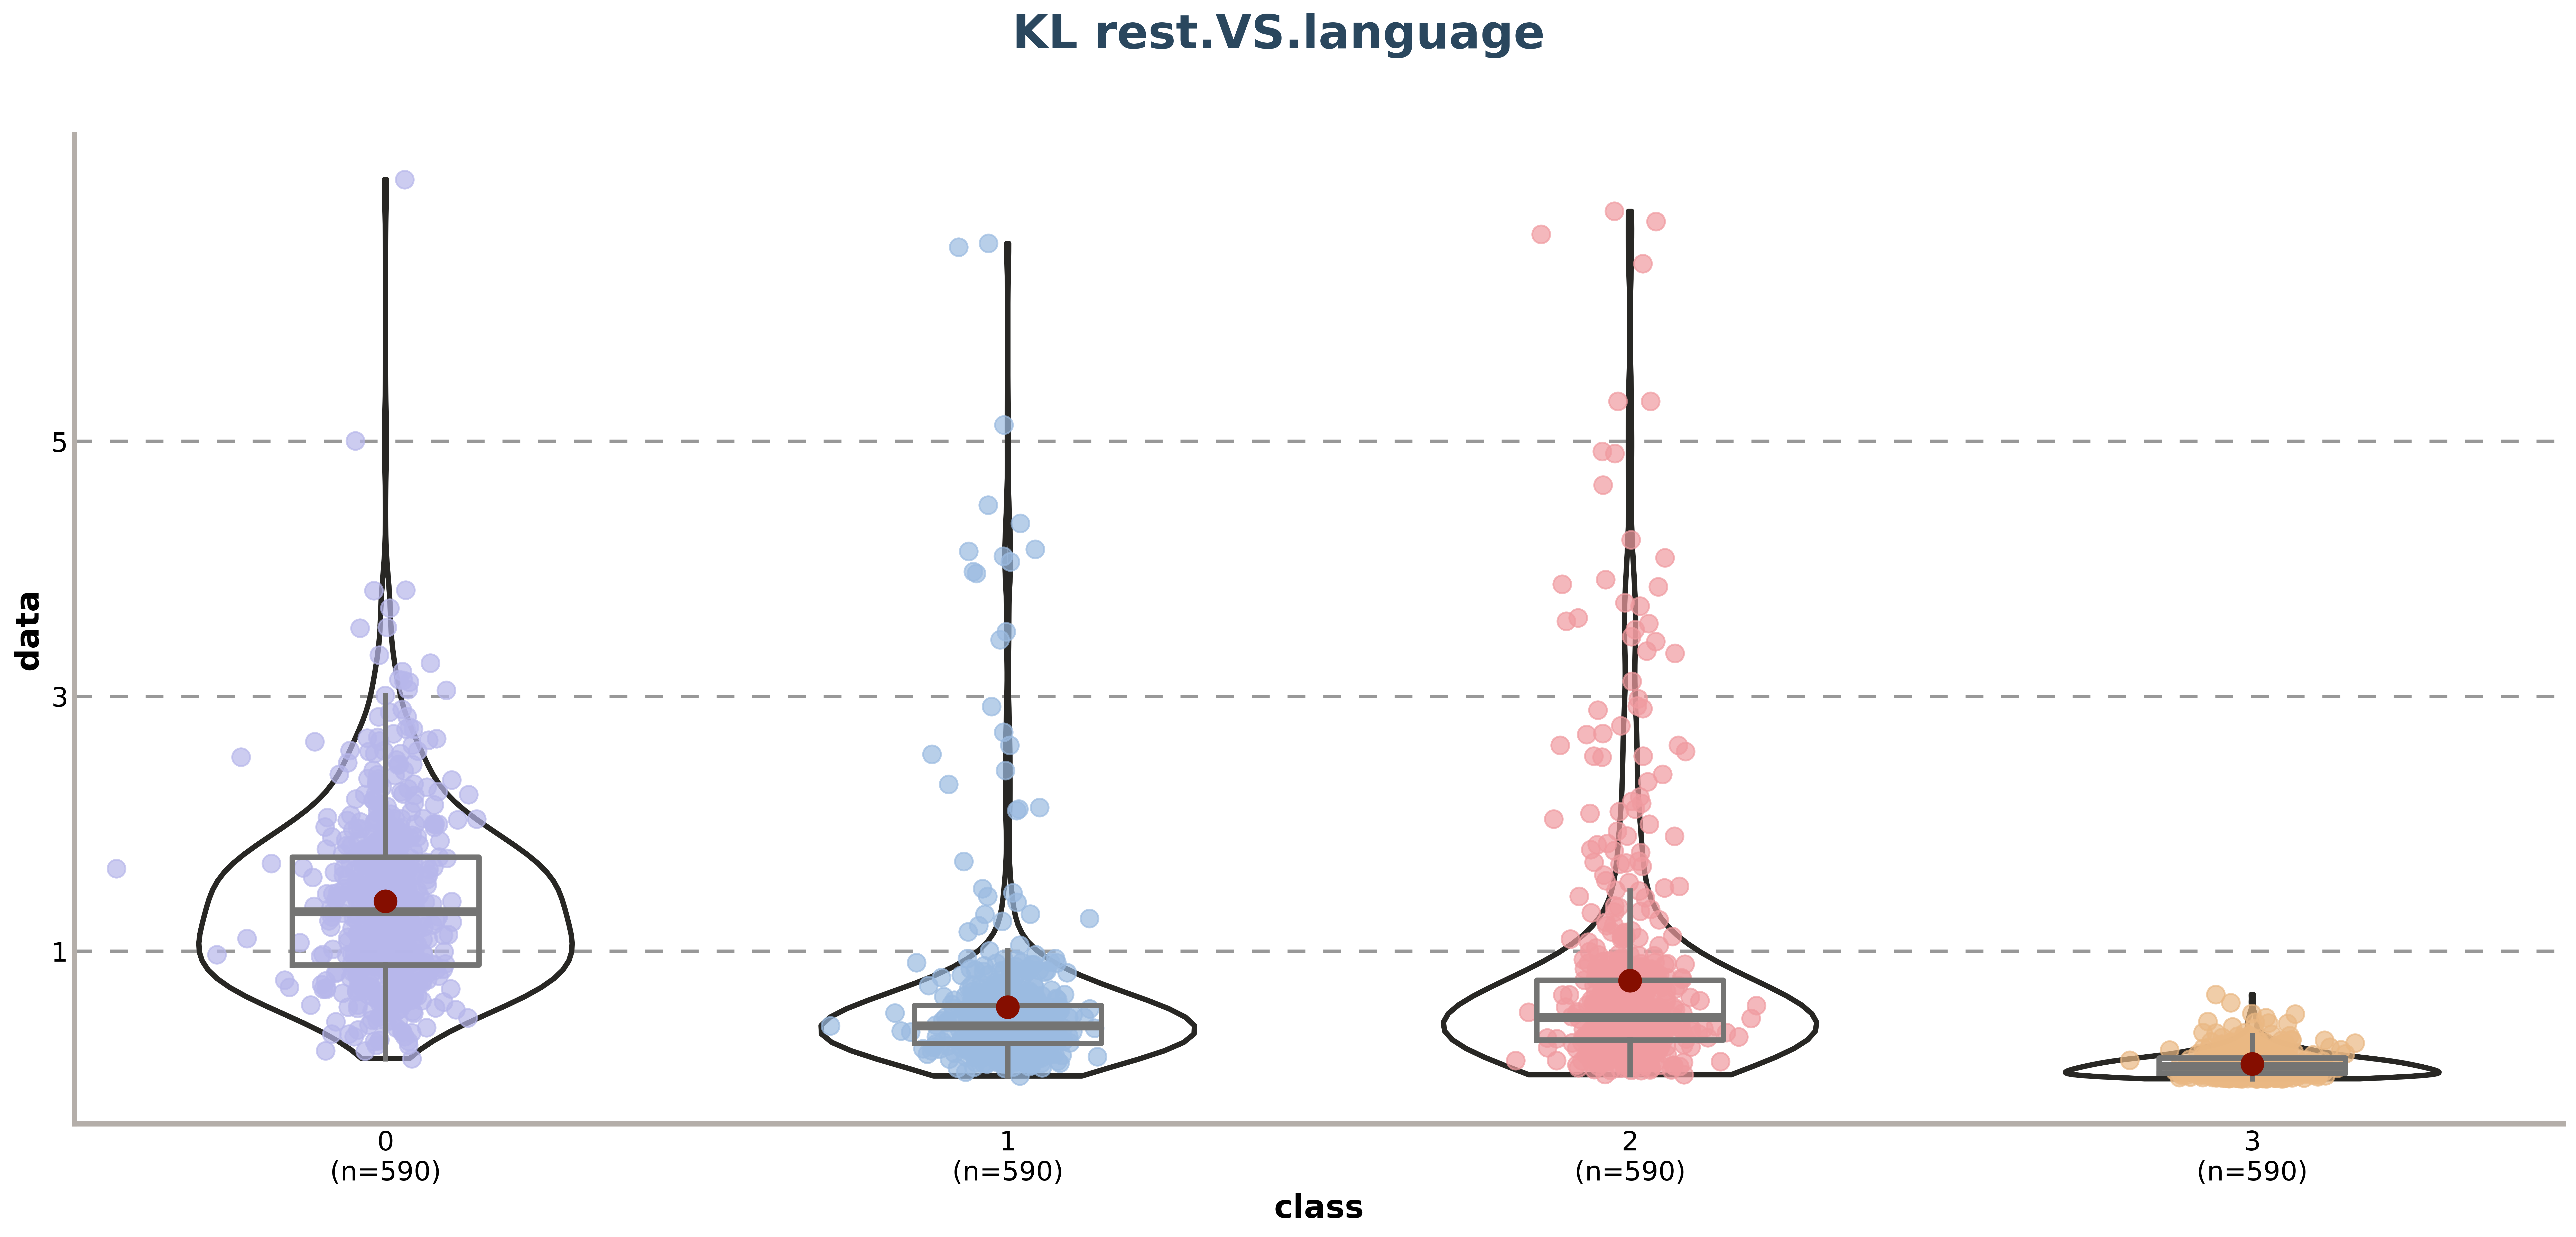

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
# kl_path = f'/data/dzy/combined_method/leida_LR.csv'

classes = sorted(data["group"].unique())  # Change the "classes" in the code to your column name "classes"
 
# prepare data
y_data = [data[data["group"] == c]["P"].values for c in classes]  


jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
 
BG_WHITE = "w"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"
COLOR_SCALE = ["#B7B7EB", 
               "#9BBBE1", 
               "#F09BA0",
               "#EAB883"]

POSITIONS = [0,1,2,3]
HLINES = [1,3,5]#sdi

fig, ax = plt.subplots(figsize=(25, 10), dpi=500)
 
# Set layout ----------------------------------------------
# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)
 
# Horizontal lines for scale reference
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0, linewidth=2)
 
# Add violin plots ----------------------------------------------------
# bw_method="silverman" means the bandwidth for kernel density estimation is calculated using Silverman's rule
 
# Output stored in 'violins' for customizing their appearance
violins = ax.violinplot(
    y_data,
    positions=POSITIONS,
    widths=0.6,
    bw_method="silverman",
    showmeans=False,
    showmedians=False,
    showextrema=False
)
 
# Customize violin plots (remove fill, customize lines, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(3)
    pc.set_alpha(1)
 
# Add box plots ---------------------------------------------------
# Note: Attributes for median and box are passed as dictionaries.
 
medianprops = dict(
    linewidth=5,
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=3,
    color=GREY_DARK
)
 
ax.boxplot(
    y_data,
    positions=POSITIONS,
    showfliers=False,  # Do not show outliers beyond box top and bottom
    showcaps=False,  # Do not show box top and bottom caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
    widths=0.3
)
 
# Add jittered points ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s=100, color=color, alpha=0.7)
        
# Add mean value labels  ------------------------------------------
means = [y.mean() for y in y_data]
for i, mean in enumerate(means):
    # Add points representing mean values
    ax.scatter(i, mean, s=150, color=RED_DARK, zorder=3)

 
# Customize layout -----------------------------------------------
# Hide axes
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
 
# Customize axis colors
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(3)
 
# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=15)
ax.set_ylabel("data", size=18, weight="bold")
 
# X-axis labels include sample size for each class
xlabels = [f"{classes}\n(n={y_data[i].size})" for i, classes in enumerate(classes)]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=15, ha="center", ma="center")
ax.set_xlabel("class", size=18, weight="bold")
 
# Title
fig.suptitle(
#     "dwell_time",
    "KL rest.VS.language",
    x = 0.5,
    y = 0.975,
    ha="center",
    fontsize=26,
    fontname="Lobster Two",
    color=BLUE,
    weight="bold",
)
plt.savefig(r"/data/dzy/bids_INV2/derivatives/brainstate/figure/KL_rest_VS_language.png", dpi=500) 
# plt.savefig(r"/data/dzy/combined_method/figure//MNR(condition).png", dpi=500) 
# Display the figure
plt.show()

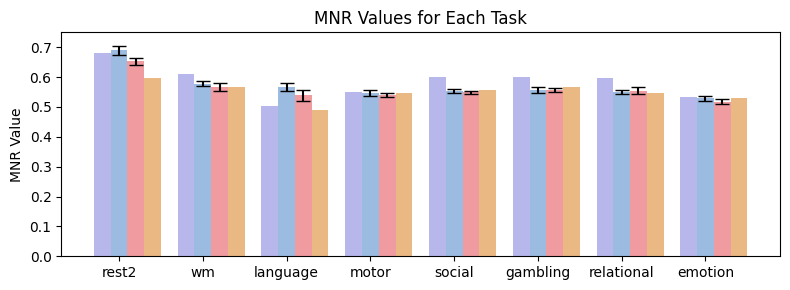

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# The data has been stored in two Dataframes, named df_roi_mnr and df_net_mnr
data_net = {
    'rest2': [0.629068, 0.640469, 0.640446, 0.664097, 0.657711, 0.666992, 0.655357, 0.654027, 0.660059, 0.658651],
    'wm': [0.552180, 0.573497, 0.589225, 0.565092, 0.570093, 0.590499, 0.559441, 0.568655, 0.557283, 0.549986],
    'language': [0.543479, 0.507293, 0.511439, 0.533933, 0.555557, 0.533413, 0.558847, 0.557290, 0.555109, 0.535944],
    'motor': [0.537310, 0.543289, 0.551701, 0.543695, 0.537349, 0.548199, 0.540708, 0.535562, 0.532352, 0.537485],
    'social': [0.555957, 0.553491, 0.544817, 0.552929, 0.547340, 0.551399, 0.545666, 0.542251, 0.544296, 0.550664],
    'gambling': [0.542710, 0.565372, 0.564547, 0.552389, 0.559037, 0.558432, 0.556314, 0.553667, 0.562134, 0.556909],
    'relational': [0.533838, 0.542923, 0.561844, 0.549850, 0.554623, 0.566353, 0.556094, 0.554016, 0.569779, 0.557572],
    'emotion': [0.500155, 0.509554, 0.516325, 0.521538, 0.515385, 0.529753, 0.510744, 0.525301, 0.523718, 0.522848]
}
df_net_mnr = pd.DataFrame(data_net, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

data_roi = {
    'rest2': [0.654589, 0.676642, 0.696080, 0.692641, 0.698434, 0.695458, 0.706511, 0.701304, 0.688575, 0.681948],
    'wm': [0.560875, 0.579085, 0.591853, 0.580660, 0.584529, 0.573495, 0.578552, 0.576461, 0.582275, 0.574465],
    'language': [0.542351, 0.551534, 0.571130, 0.561308, 0.585895, 0.580714, 0.571208, 0.572502, 0.572120, 0.566741],
    'motor': [0.530988, 0.527327, 0.548299, 0.540052, 0.547726, 0.556937, 0.564333, 0.554909, 0.544628, 0.550087],
    'social': [0.547845, 0.547029, 0.545728, 0.548793, 0.559513, 0.551298, 0.563764, 0.558573, 0.554409, 0.559640],
    'gambling': [0.535528, 0.559200, 0.546748, 0.560684, 0.559123, 0.563916, 0.565669, 0.569193, 0.559533, 0.555088],
    'relational': [0.534644, 0.551419, 0.556049, 0.548968, 0.555726, 0.548108, 0.552568, 0.551609, 0.548760, 0.552955],
    'emotion': [0.539560, 0.530030, 0.525359, 0.528826, 0.513225, 0.525342, 0.524609, 0.530377, 0.536346, 0.543184]
}
df_roi_mnr = pd.DataFrame(data_roi, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

data_cm = {
    'rest2': [0.680567],
    'wm': [0.609582],
    'language': [0.504861],
    'motor': [0.550593],
    'social': [0.599832],
    'gambling': [0.600459],
    'relational': [0.595871],
    'emotion': [0.534105]
}
df_cm_mnr = pd.DataFrame(data_cm, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
data_el = {
    'rest2': [0.598199],
    'wm': [0.568378],
    'language': [0.490797],
    'motor': [0.545369],
    'social': [0.555394],
    'gambling': [0.566541],
    'relational': [0.545985],
    'emotion': [0.528919]
}
df_el_mnr = pd.DataFrame(data_el, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Calculate the mean and standard deviation of MNR for each task
mnr_means_roi = df_roi_mnr.mean()
mnr_std_roi = df_roi_mnr.std()
mnr_means_net = df_net_mnr.mean()
mnr_std_net = df_net_mnr.std()
mnr_means_cm = df_cm_mnr.mean()
mnr_std_cm = df_cm_mnr.std()
mnr_means_el = df_el_mnr.mean()
mnr_std_el = df_el_mnr.std()

# Set the figure size and bar positions
tasks = mnr_means_roi.index
bar_width = 0.2
index = np.arange(len(tasks))

# Plot bar charts with error bars
plt.figure(figsize=(8, 3))
bar3 = plt.bar(index , mnr_means_cm, bar_width, label='CM MNR', color='#B7B7EB')
bar1 = plt.bar(index + bar_width, mnr_means_roi, bar_width, yerr=mnr_std_roi, capsize=5, label='ROI MNR', color='#9BBBE1')
bar2 = plt.bar(index + 2 * bar_width, mnr_means_net, bar_width, yerr=mnr_std_net, capsize=5, label='Net MNR', color='#F09BA0')
bar4 = plt.bar(index + 3 * bar_width, mnr_means_el, bar_width, label='EL MNR', color='#EAB883')

# Add labels and title
plt.ylabel('MNR Value')
plt.title('MNR Values for Each Task')
plt.xticks(index + 2 * bar_width / 2, tasks)  # Set x-axis label positions
plt.ylim([0,0.75])
# Add legend
# plt.legend()
plt.tight_layout()  # Adjust layout
plt.show()


In [ ]:
## Calculate KL divergence of state spaces identified by EPLSA across different tasks
import os
folder_path_LR = '/data/dzy/combined_method/结合方法/results_RL_net/'
# folder_path_RL = '/data/dzy/combined_method/结合方法/results_RL_net/'
# File list
file_names = ['Dynamics_REST1.csv', 'Dynamics_MOTOR.csv', 'Dynamics_EMOTION.csv',
              'Dynamics_GAMBLING.csv', 'Dynamics_LANGUAGE.csv', 'Dynamics_RELATIONAL.csv', 'Dynamics_SOCIAL.csv', 'Dynamics_WM.csv']
condition = ['rest1', 'motor', 'emotion', 'gambling', 'language', 'relational', 'social', 'wm']
combined_method_kl = []
for file_name1, file_name2 in itertools.combinations(file_names, 2):
    task1 = next(cond for cond, fname in zip(condition, file_names) if fname == file_name1)
    task2 = next(cond for cond, fname in zip(condition, file_names) if fname == file_name2)
    # Construct complete file paths
    file_path1_LR = os.path.join(folder_path_LR, file_name1)
#     file_path1_RL = os.path.join(folder_path_RL, file_name1)
    # Read CSV files
    data1_LR = pd.read_csv(file_path1_LR)
#     data1_RL = pd.read_csv(file_path1_RL)
    data1_LR = data1_LR.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4',' Frequency of B5',' Frequency of B6',' Frequency of B7',' Frequency of B8',' Frequency of B9',' Frequency of B10',' Frequency of B11',' Frequency of B12']]
    data1_LR = pd.DataFrame(data1_LR, dtype=float)
#     data1_RL = data1_RL.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4',' Frequency of B5',' Frequency of B6',' Frequency of B7',' Frequency of B8',' Frequency of B9',' Frequency of B10',' Frequency of B11',' Frequency of B12']]
#     data1_RL = pd.DataFrame(data1_RL, dtype=float)
    file_path2_LR = os.path.join(folder_path_LR, file_name2)
#     file_path2_RL = os.path.join(folder_path_RL, file_name2)
# Read CSV files
    data2_LR = pd.read_csv(file_path2_LR)
#     data2_RL = pd.read_csv(file_path2_RL)
    data2_LR = data2_LR.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4',' Frequency of B5',' Frequency of B6',' Frequency of B7',' Frequency of B8',' Frequency of B9',' Frequency of B10',' Frequency of B11',' Frequency of B12']]
    data2_LR = pd.DataFrame(data2_LR, dtype=float)
#     data2_RL = data2_RL.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4',' Frequency of B5',' Frequency of B6',' Frequency of B7',' Frequency of B8',' Frequency of B9',' Frequency of B10',' Frequency of B11',' Frequency of B12']]
#     data2_RL = pd.DataFrame(data2_RL, dtype=float)
    kl={}
    for i in range(0,590):
        data1 = data1_LR.loc[i,:]
        data2 = data2_LR.loc[i,:]
        kl[i] = kl_divergence(data1,data2)

    kl = pd.Series(kl)
    kl = remove_outliers(kl)
    kl_values = kl.values.tolist()
#     kl_values = list(kl.values())
    mean_kl = np.mean(kl_values)
    combined_method_kl.append({'task1':task1, 'task2':task2, 'mean_kl':mean_kl})
            
# Print results
for result in combined_method_kl:
    print(f"task1: {result['task1']}, task2: {result['task2']}, mean_kl: {result['mean_kl']}")
df1 = pd.DataFrame(combined_method_kl)
# Save the DataFrame as a CSV file
df1.to_csv('/data/dzy/combined_method/EPLSA_RL_kl.csv', index=False, encoding='utf-8')

task1: rest1, task2: motor, mean_kl: 0.98362724947286
task1: rest1, task2: emotion, mean_kl: 1.4787136737703415
task1: rest1, task2: gambling, mean_kl: 1.250202036683229
task1: rest1, task2: language, mean_kl: 0.9982032484081277
task1: rest1, task2: relational, mean_kl: 1.4234959037171826
task1: rest1, task2: social, mean_kl: 1.0753136795660545
task1: rest1, task2: wm, mean_kl: 0.9592469614461817
task1: motor, task2: emotion, mean_kl: 2.4224055149745434
task1: motor, task2: gambling, mean_kl: 1.8112131880321232
task1: motor, task2: language, mean_kl: 2.0858485074506885
task1: motor, task2: relational, mean_kl: 2.0910917892078826
task1: motor, task2: social, mean_kl: 2.1322411983962053
task1: motor, task2: wm, mean_kl: 1.483803926832989
task1: emotion, task2: gambling, mean_kl: 2.3218249570290452
task1: emotion, task2: language, mean_kl: 2.17087146543108
task1: emotion, task2: relational, mean_kl: 2.2969380635908694
task1: emotion, task2: social, mean_kl: 2.9171608939259537
task1: emoti

In [ ]:
##Calculate KL divergence of state spaces identified by ELA across different tasks
import os
folder_path_LR = '/data/dzy/combined_method/原始能量景观分析/results_RL/'
# folder_path_RL = '/data/dzy/combined_method/原始能量景观分析/results_RL/'

file_names = ['Dynamics_REST1.csv', 'Dynamics_MOTOR.csv', 'Dynamics_EMOTION.csv',
              'Dynamics_GAMBLING.csv', 'Dynamics_LANGUAGE.csv', 'Dynamics_RELATIONAL.csv', 'Dynamics_SOCIAL.csv', 'Dynamics_WM.csv']
condition = ['rest1', 'motor', 'emotion', 'gambling', 'language', 'relational', 'social', 'wm']
energy_landscape_kl = []

for file_name1, file_name2 in itertools.combinations(file_names, 2):
    task1 = next(cond for cond, fname in zip(condition, file_names) if fname == file_name1)
    task2 = next(cond for cond, fname in zip(condition, file_names) if fname == file_name2)

    file_path1_LR = os.path.join(folder_path_LR, file_name1)
#     file_path1_RL = os.path.join(folder_path_RL, file_name1)

    data1_LR = pd.read_csv(file_path1_LR)
#     data1_RL = pd.read_csv(file_path1_RL)
    data1_LR = data1_LR.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4']]
    data1_LR = pd.DataFrame(data1_LR, dtype=float)
#     data1_RL = data1_RL.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4']]
#     data1_RL = pd.DataFrame(data1_RL, dtype=float)
    file_path2_LR = os.path.join(folder_path_LR, file_name2)
#     file_path2_RL = os.path.join(folder_path_RL, file_name2)

    data2_LR = pd.read_csv(file_path2_LR)
#     data2_RL = pd.read_csv(file_path2_RL)
    data2_LR = data2_LR.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4']]
    data2_LR = pd.DataFrame(data2_LR, dtype=float)
#     data2_RL = data2_RL.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4']]
#     data2_RL = pd.DataFrame(data2_RL, dtype=float)
    kl2={}
    for i in range(0,590):
        data1 = data1_LR.loc[i,:]
        data2 = data2_LR.loc[i,:]
        kl2[i] = kl_divergence(data1,data2)
    kl2 = pd.Series(kl2)
    kl2 = remove_outliers(kl2)
    kl2_values = kl2.values.tolist()
#     kl2_values = list(kl2.values())  
    mean_kl2 = np.mean(kl2_values)
    energy_landscape_kl.append({'task1':task1, 'task2':task2, 'mean_kl':mean_kl2})
            

for result in energy_landscape_kl:
    print(f"task1: {result['task1']}, task2: {result['task2']}, mean_kl: {result['mean_kl']}")
df2 = pd.DataFrame(energy_landscape_kl)

df2.to_csv('/data/dzy/combined_method/原始能量景观分析_RL_kl.csv', index=False, encoding='utf-8')

task1: rest1, task2: motor, mean_kl: 0.02462745283605931
task1: rest1, task2: emotion, mean_kl: 0.030375326635693416
task1: rest1, task2: gambling, mean_kl: 0.029213467220050155
task1: rest1, task2: language, mean_kl: 0.0440964377282527
task1: rest1, task2: relational, mean_kl: 0.034794940477952487
task1: rest1, task2: social, mean_kl: 0.02840175463986773
task1: rest1, task2: wm, mean_kl: 0.018831850835403275
task1: motor, task2: emotion, mean_kl: 0.04343751264924916
task1: motor, task2: gambling, mean_kl: 0.03724669946958729
task1: motor, task2: language, mean_kl: 0.05844088923497655
task1: motor, task2: relational, mean_kl: 0.040584542139567525
task1: motor, task2: social, mean_kl: 0.03709579481026916
task1: motor, task2: wm, mean_kl: 0.030181049769054728
task1: emotion, task2: gambling, mean_kl: 0.04671797234342148
task1: emotion, task2: language, mean_kl: 0.05828430580562807
task1: emotion, task2: relational, mean_kl: 0.051824694813992746
task1: emotion, task2: social, mean_kl: 0.0

In [ ]:
## Compare KL divergences obtained by three methods
from scipy.stats import entropy, ttest_ind
import matplotlib.pyplot as plt
import numpy as np  # Added missing numpy import (required for np.arange)
# Convert dictionaries to lists
kl_values = list(kl.values())#combined_method
kl1_values = list(kl1.values())#leida
kl2_values = list(kl2.values())#energy_landscape
# print(kl_values)
# print(kl1_values)
# Perform t-tests
t_stat1, p_val1 = ttest_ind(kl_values, kl1_values)
t_stat2, p_val2 = ttest_ind(kl_values, kl2_values)
t_stat3, p_val3 = ttest_ind(kl1_values, kl2_values)
# Print t-test results
print(f"leida .vs. combined_method: t-statistic: {t_stat1}, p-value: {p_val1}")
print(f"energy_landscape .vs. combined_method: t-statistic: {t_stat2}, p-value: {p_val2}")
print(f"energy_landscape .vs. leida: t-statistic: {t_stat3}, p-value: {p_val3}")
# Plot comparison of the three datasets
# Calculate bar width and positions
bar_width = 0.35  # Width of the bars
index = np.arange(len(kl_values))  # Position index of the bars

# Plot bar chart
plt.figure(figsize=(10, 6))

# Plot bars for each method
plt.bar(index - bar_width, kl2_values, bar_width, alpha=0.6, label='energy_landscape')
plt.bar(index, kl_values, bar_width, alpha=0.6, label='combined method')
plt.bar(index + bar_width, kl1_values, bar_width, alpha=0.6, label='Leida')

plt.xlabel('Index')
plt.ylabel('KL Divergence')
plt.title('Comparison of combined method and Leida and energy_landscape')
plt.legend()
plt.show()

# kl: combined method, kl1: Leida, kl2: energy_landscape
mean_kl = np.mean(kl_values)
mean_kl1 = np.mean(kl1_values)
mean_kl2 = np.mean(kl2_values)

# Plot bar chart for mean values
plt.figure(figsize=(6, 6))
plt.bar(['energy_landscape','combined method', 'leida'], [mean_kl2, mean_kl, mean_kl1], color=['blue', 'orange', 'green'])

# Add text labels for mean values
plt.text('energy_landscape', mean_kl2, f'{mean_kl2:.2f}', ha='center', va='bottom')
plt.text('combined method', mean_kl, f'{mean_kl:.2f}', ha='center', va='bottom')
plt.text('leida', mean_kl1, f'{mean_kl1:.2f}', ha='center', va='bottom')

plt.xlabel('Type')
plt.ylabel('Mean KL Divergence')
# plt.title('Comparison of Mean KL and Mean KL1')
plt.show()

- MNR

In [ ]:
import numpy as np
import pandas as pd
import os
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

def Compute_mnr(D, ID):
    """
    Computes the Mean Nearest Rank (MNR) for the given data.

    Parameters:
    D : numpy.ndarray
        An n x n matrix recording pairwise distances between subjects,表示个体间的成对距离
    ID : numpy.ndarray or list
        A vector of length n representing the subject id of each row of D，D中每一行对应的个体标识

    Returns:
    MNR : float
        Mean Nearest Rank of the data set.
    stdMNR : float
        Standard error of MNR estimate.
    MNRs : list
        All MNRs for each pair of observations.
    """
    n = len(ID)
    ranks = 0
    rankij = []
    count = 0
    MNRs = []

    for i in range(n):
        # Find indices with the same ID as the current element
        ind = np.where(ID == ID[i])[0] #Find the index with the same ID as i
        s = len(ind)
        for j in ind:
            di = D[i, :].copy()
            d = D[i, j]
            # Set distances within the same group to infinity
            di[ind] = np.inf

            if i != j:
                # Calculate rank
                r = 1 - (np.sum(di < d) + 0.5 * np.sum(di == d)) / (n - s)
                ranks += r
                count += 1
                rankij.append(r)
                MNRs.append(r)

    # Calculate Mean Nearest Rank
    MNR = ranks / count

    # Calculate standard error if needed
    if len(rankij) > 1:
        stdMNR = np.sqrt(np.var(rankij) / count)
    else:
        stdMNR = 0

    return MNR, stdMNR, MNRs

def graph_todist(graphs):
    """
    Computes the pairwise distance between graphs.

    Parameters:
    graphs : numpy.ndarray
        A 3D array of shape (k, k, n), where n is the number of graphs and each graph is k x k.

    Returns:
    D : numpy.ndarray
        An n x n distance matrix between the graphs.
    """
    
    D = squareform(pdist(graphs, 'euclidean'))

    return D

def get_mnr(grad,ID):
    D = graph_todist(grad)
    MNR, stdMNR, MNRs = Compute_mnr(D, ID)
    return (MNR, stdMNR, MNRs)

[[0.62806526 0.63103692 0.64240743 0.65708189 0.66791649 0.67021207
  0.66459988 0.66287724 0.65945134 0.66081451 0.65538098 0.65560688
  0.65101107 0.64940549 0.64835642 0.65673773 0.65561988 0.65653897
  0.65391283]]


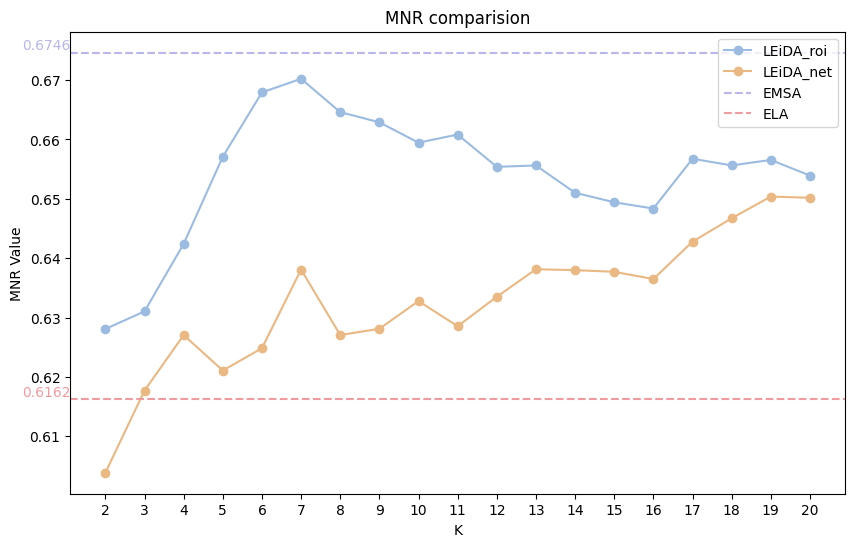

In [ ]:
##Compare the MNR of the four methods
mnr_list_roi = []
condition = ['rest1', 'rest2', 'motor', 'emotion', 'gambling', 'language', 'relational', 'social', 'wm']
for k in range(2,21):
    occ_data1 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR/dynamics_metrics/k_{k}/occupancies.csv',sep='\t')
    dt_data1 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR/dynamics_metrics/k_{k}/dwell_times.csv',sep='\t')
    trans_data1 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR/dynamics_metrics/k_{k}/transitions_probabilities.csv',sep='\t')
    subjects = len(occ_data1['subject_id'])
    occ_data1 = occ_data1.drop(['subject_id','condition'], axis=1)
    dt_data1 = dt_data1.drop(['subject_id','condition'], axis=1)
    trans_data1 = trans_data1.drop(['subject_id','condition'], axis=1)
    data1 = pd.concat([occ_data1,dt_data1, trans_data1], axis=1)

    occ_data2 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL/dynamics_metrics/k_{k}/occupancies.csv',sep='\t')
    dt_data2 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL/dynamics_metrics/k_{k}/dwell_times.csv',sep='\t')
    trans_data2 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL/dynamics_metrics/k_{k}/transitions_probabilities.csv',sep='\t')
    occ_data2 = occ_data2.drop(['subject_id','condition'], axis=1)
    dt_data2 = dt_data2.drop(['subject_id','condition'], axis=1)
    trans_data2 = trans_data2.drop(['subject_id','condition'], axis=1)
    data2 = pd.concat([occ_data2,dt_data2,trans_data2], axis=1)
#     data = np.row_stack((dt_data1, dt_data2))
    data = np.row_stack((data1, data2))
    ID = np.tile(np.arange(1, subjects + 1), 2)
    mnr, _, _ = get_mnr(data, ID)
    mnr_list_roi.append(mnr)
mnr_matrix_roi = np.array(mnr_list_roi).reshape(-1, 19)
print(mnr_matrix_roi)

mnr_list_net = []
for k in range(2,21):
    occ_data3 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR_net/dynamics_metrics/k_{k}/occupancies.csv',sep='\t')
    dt_data3 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR_net/dynamics_metrics/k_{k}/dwell_times.csv',sep='\t')
    trans_data3 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR_net/dynamics_metrics/k_{k}/transitions_probabilities.csv',sep='\t')
    subjects = len(occ_data3['subject_id'])
    occ_data3 = occ_data3.drop(['subject_id','condition'], axis=1)
    dt_data3 = dt_data3.drop(['subject_id','condition'], axis=1)
    trans_data3 = trans_data3.drop(['subject_id','condition'], axis=1)
    data3 = pd.concat([occ_data3,dt_data3, trans_data3], axis=1)

    occ_data4 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL_net/dynamics_metrics/k_{k}/occupancies.csv',sep='\t')
    dt_data4 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL_net/dynamics_metrics/k_{k}/dwell_times.csv',sep='\t')
    trans_data4 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL_net/dynamics_metrics/k_{k}/transitions_probabilities.csv',sep='\t')
    occ_data4 = occ_data4.drop(['subject_id','condition'], axis=1)
    dt_data4 = dt_data4.drop(['subject_id','condition'], axis=1)
    trans_data4 = trans_data4.drop(['subject_id','condition'], axis=1)
    data4 = pd.concat([occ_data4,dt_data4, trans_data4], axis=1)
#     data_net = np.row_stack((dt_data3, dt_data4))
    data_net = np.row_stack((data3, data4))
    ID = np.tile(np.arange(1, subjects + 1), 2)
    mnr, _, _ = get_mnr(data_net, ID)
    mnr_list_net.append(mnr)
mnr_matrix_net = np.array(mnr_list_net).reshape(-1, 19)

plt.figure(figsize=(10, 6))  
plt.plot(range(2, 21), mnr_matrix_roi[0], marker='o',label='LEiDA_roi',color='#9BBBE1') 
plt.plot(range(2, 21), mnr_matrix_net[0], marker='o',label='LEiDA_net',color='#EAB883') 
plt.xticks(np.arange(2, 21))
plt.title('MNR comparision')
plt.xlabel('K')
plt.ylabel('MNR Value')
# for i, (x, y) in enumerate(zip(range(2, 21), mnr_matrix_roi[0])):
#     plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')
# for i, (x, y) in enumerate(zip(range(2, 21), mnr_matrix_net[0])):
#     plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')
    
#EPLSA
plt.axhline(y=0.6746, color='#B7B7EB', linestyle='--', label='combined_method')
plt.text(0.5, 0.6746, f'{0.6746:.4f}', ha='center', va='bottom', color='#B7B7EB')
##ELA
plt.axhline(y=0.6162, color='#F09BA0', linestyle='--', label='energy_landscape')
plt.text(0.5, 0.6162, f'{0.6162:.4f}', ha='center', va='bottom', color='#F09BA0')

plt.legend(['LEiDA_roi','LEiDA_net','EMSA','ELA'])
plt.show()

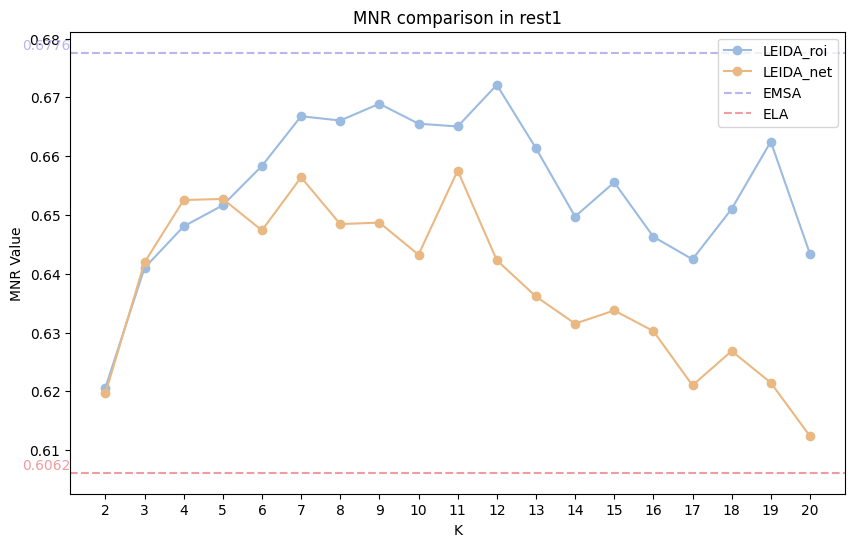

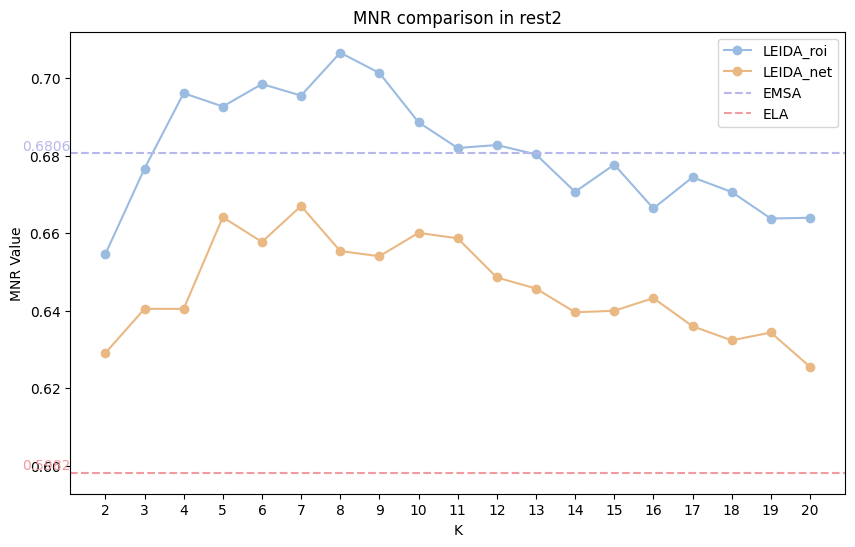

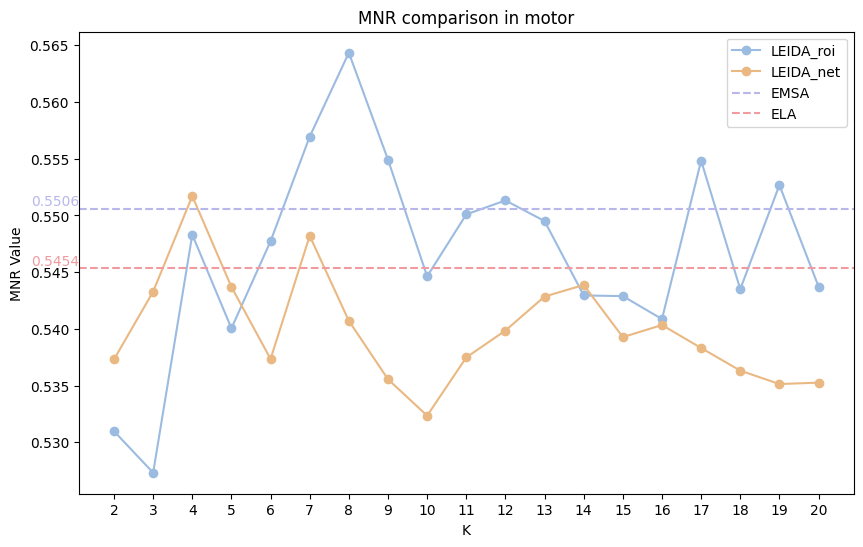

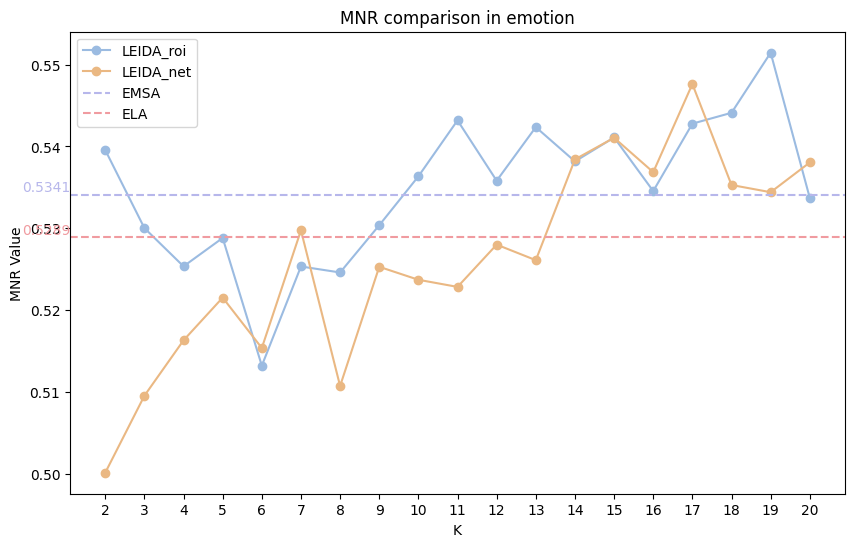

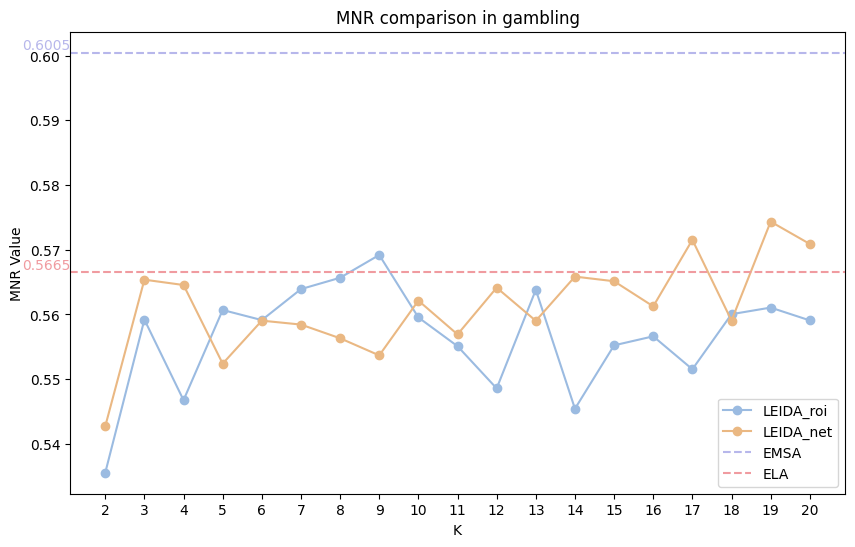

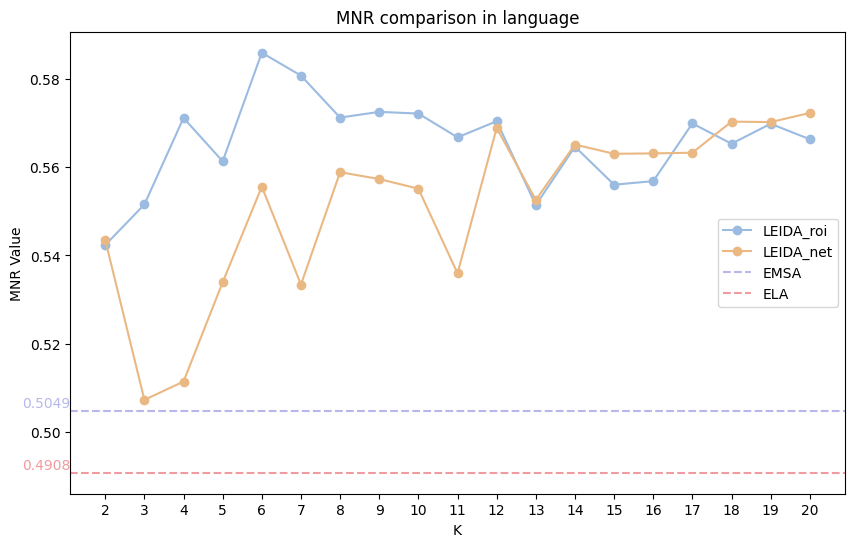

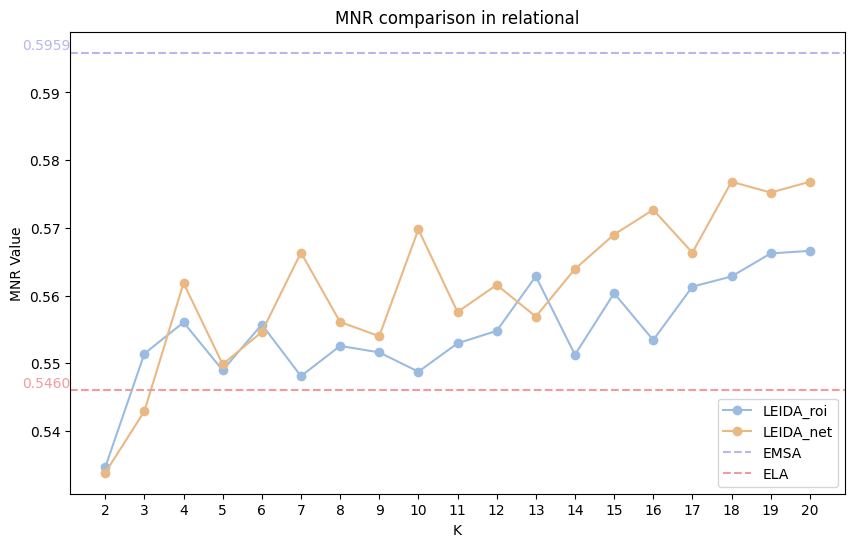

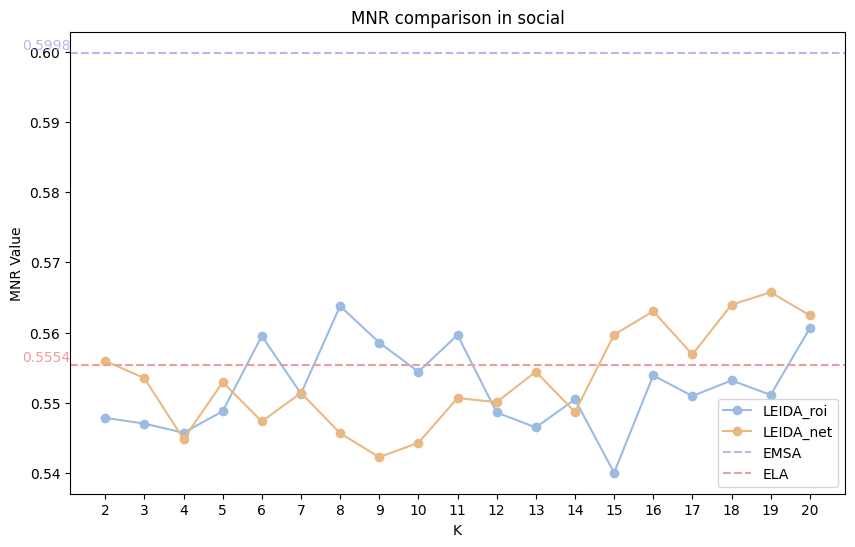

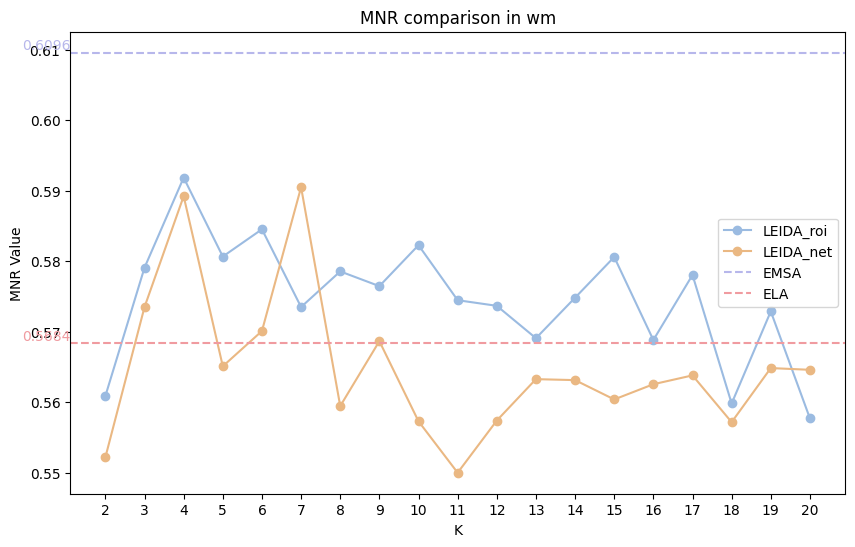

In [ ]:
##Comparison of MNR by task
MNR_roi = []
MNR_net = []
conditions = ['rest1', 'rest2', 'motor', 'emotion', 'gambling', 'language', 'relational', 'social', 'wm']
for condition in conditions:
    mnr_list_roi = []
    mnr_list_net = []
    for k in range(2,21):
        occ_data1 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR/dynamics_metrics/k_{k}/occupancies.csv',sep='\t')
        dt_data1 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR/dynamics_metrics/k_{k}/dwell_times.csv',sep='\t')
        trans_data1 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR/dynamics_metrics/k_{k}/transitions_probabilities.csv',sep='\t')
#     occ_data1 = occ_data1.drop(['subject_id','condition'], axis=1)
        dt_data1 = dt_data1.drop(['subject_id','condition'], axis=1)
        trans_data1 = trans_data1.drop(['subject_id','condition'], axis=1)
        data1 = pd.concat([occ_data1,dt_data1,trans_data1], axis=1)

        occ_data2 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL/dynamics_metrics/k_{k}/occupancies.csv',sep='\t')
        dt_data2 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL/dynamics_metrics/k_{k}/dwell_times.csv',sep='\t')
        trans_data2 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL/dynamics_metrics/k_{k}/transitions_probabilities.csv',sep='\t')
#     occ_data2 = occ_data2.drop(['subject_id','condition'], axis=1)
        dt_data2 = dt_data2.drop(['subject_id','condition'], axis=1)
        trans_data2 = trans_data2.drop(['subject_id','condition'], axis=1)
        data2 = pd.concat([occ_data2,dt_data2,trans_data2], axis=1)
#         data_task1 = occ_data1[occ_data1['condition'] == condition]
        data_task1 = data1[data1['condition'] == condition]
        subjects = len(data_task1['subject_id'])
#         print(subjects)
        data_task1 = data_task1.drop(['subject_id','condition'], axis=1)
#         data_task2 = occ_data2[occ_data2['condition'] == condition]
        data_task2 = data2[data2['condition'] == condition]
        data_task2 = data_task2.drop(['subject_id','condition'], axis=1)
        data_roi = np.row_stack((data_task1, data_task2))
        
        occ_data3 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR_net/dynamics_metrics/k_{k}/occupancies.csv',sep='\t')
        dt_data3 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR_net/dynamics_metrics/k_{k}/dwell_times.csv',sep='\t')
        trans_data3 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_LR_net/dynamics_metrics/k_{k}/transitions_probabilities.csv',sep='\t')
        dt_data3 = dt_data3.drop(['subject_id','condition'], axis=1)
        trans_data3 = trans_data3.drop(['subject_id','condition'], axis=1)
        data3 = pd.concat([occ_data3,dt_data3,trans_data3], axis=1)

        occ_data4 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL_net/dynamics_metrics/k_{k}/occupancies.csv',sep='\t')
        dt_data4 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL_net/dynamics_metrics/k_{k}/dwell_times.csv',sep='\t')
        trans_data4 = pd.read_csv(f'/data/dzy/combined_method/NET/LEiDA_results_RL_net/dynamics_metrics/k_{k}/transitions_probabilities.csv',sep='\t')
#     occ_data2 = occ_data2.drop(['subject_id','condition'], axis=1)
        dt_data4 = dt_data4.drop(['subject_id','condition'], axis=1)
        trans_data4 = trans_data4.drop(['subject_id','condition'], axis=1)
        data4 = pd.concat([occ_data4,dt_data4,trans_data4], axis=1)
#         data_task3 = occ_data3[occ_data3['condition'] == condition]
        data_task3 = data3[data3['condition'] == condition]
        subjects = len(data_task3['subject_id'])
#         print(subjects)
        data_task3 = data_task3.drop(['subject_id','condition'], axis=1)
#         data_task4 = occ_data4[occ_data4['condition'] == condition]
        data_task4 = data4[data4['condition'] == condition]
        data_task4 = data_task4.drop(['subject_id','condition'], axis=1)
        data_net = np.row_stack((data_task3, data_task4))
        
        ID = np.tile(np.arange(1, subjects + 1), 2)
        mnr_roi, _, _ = get_mnr(data_roi, ID)
        mnr_net, _, _ = get_mnr(data_net, ID)
        mnr_list_roi.append(mnr_roi)
        mnr_list_net.append(mnr_net)
        MNR_roi.append({'k': k, 'task': condition, 'MNR': mnr_roi})
        MNR_net.append({'k': k, 'task': condition, 'MNR': mnr_net})
# MNR_roi = pd.DataFrame(MNR_roi)
# MNR_net = pd.DataFrame(MNR_net)
# MNR_roi.to_csv('/data/dzy/combined_method/roi_mnr.csv', index=False, encoding='utf-8')
# MNR_net.to_csv('/data/dzy/combined_method/net_mnr.csv', index=False, encoding='utf-8')
    mnr_matrix_roi = np.array(mnr_list_roi).reshape(-1, 19)
    mnr_matrix_net = np.array(mnr_list_net).reshape(-1, 19)
    
    
    plt.figure(figsize=(10, 6))  
    plt.plot(range(2, 21), mnr_matrix_roi[0], marker='o',label='LEIDA_roi',color='#9BBBE1') 
    plt.plot(range(2, 21), mnr_matrix_net[0], marker='o',label='LEIDA_net',color='#EAB883') 
    plt.xticks(np.arange(2, 21))

    plt.title(f'MNR comparison in {condition}')
    plt.xlabel('K')
    plt.ylabel('MNR Value')
#     for i, (x, y) in enumerate(zip(range(2, 21), mnr_matrix_roi[0])):
#         plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')
#     for i, (x, y) in enumerate(zip(range(2, 21), mnr_matrix_net[0])):
#         plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')
    
    mnr_combined = pd.read_csv('/data/dzy/combined_method/结合方法_mnr.csv')
    mnr_combined_value = mnr_combined.loc[mnr_combined['task'] == condition, 'MNR'].values[0]
    plt.axhline(y=mnr_combined_value, color='#B7B7EB', linestyle='--', label='EMSA')
    plt.text(0.5, mnr_combined_value, f'{mnr_combined_value:.4f}', ha='center', va='bottom', color='#B7B7EB')

    mnr_energy_landscape = pd.read_csv('/data/dzy/combined_method/原始能量景观分析_mnr.csv')
    mnr_energy_landscape_value = mnr_energy_landscape.loc[mnr_energy_landscape['task'] == condition, 'MNR'].values[0]

    plt.axhline(y=mnr_energy_landscape_value, color='#F09BA0', linestyle='--', label='ELA')
    plt.text(0.5, mnr_energy_landscape_value, f'{mnr_energy_landscape_value:.4f}', ha='center', va='bottom', color='#F09BA0')
  
    plt.legend(['LEIDA_roi','LEIDA_net','EMSA','ELA'])
    plt.show()
# for result in MNR:
#     print(f"k: {result['k']}, task: {result['task']}, MNR: {result['MNR']}")